# Unit09_Integrated_Case_Study_Overview | 綜合案例研究：田納西-伊士曼製程 (TEP) 數據分析

本 Notebook 使用 `Part_2/Unit09/data/TEP_data` 資料夾中的田納西-伊士曼製程 (Tennessee Eastman Process, TEP) 數據，展示如何結合**分群 (Clustering)**、**降維 (Dimensionality Reduction)**、**異常檢測 (Anomaly Detection)** 等多種非監督式學習方法，進行完整的化工製程數據分析工作流程。

## 目標
- 理解 TEP 製程的複雜性與數據特性
- 掌握端到端的製程數據分析流程
- 實踐多種非監督式學習方法的整合應用
- 學會從數據分析結果中提取工程洞察與可操作建議

資料背景可參考：
- [TEP 原始論文](https://doi.org/10.1016/0098-1354(93)80018-I)
- [TEP GitHub Repository](http://depts.washington.edu/control/LARRY/TE/download.html)

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit09_Integrated_Case_Study'
SOURCE_DATA_DIR = 'TEP_data'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit09'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\data\TEP_data
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs


---
### 載入相關套件

In [2]:
# 數據處理與視覺化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 機器學習 - 數據預處理
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 機器學習 - 降維
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import umap

# 機器學習 - 分群
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# 機器學習 - 異常檢測
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

# 機器學習 - 模型評估
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, classification_report
)

# 階層式分群視覺化
from scipy.cluster.hierarchy import dendrogram, linkage

# 繪圖風格設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# 中文字體設定 (for Windows)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 1. 數據載入與探索性分析

### 1.1 TEP 數據簡介

田納西-伊士曼製程 (Tennessee Eastman Process, TEP) 是一個化工製程控制測試問題的標準基準案例。TEP 模擬一個連續式化學製程，包含反應器、分離器、汽提塔等多個單元操作。

**數據特性**：
- **52 個變數**：41 個測量變數 (XMEAS 1-41) + 11 個操作變數 (XMV 1-11)
- **多種故障場景**：21 種預定義故障 (IDV 1-21) + 正常操作 (IDV 0)
- **訓練數據**：480 個時間點 (24 小時，每 3 分鐘採樣)
- **測試數據**：960 個時間點 (48 小時，每 3 分鐘採樣)

在本範例中，我們將使用正常操作數據進行分析，並展示完整的非監督式學習工作流程。

### 1.2 數據載入函數

In [3]:
def load_tep_data(data_dir, fault_id=0, data_type='train'):
    """
    載入 TEP 數據集
    
    參數:
        data_dir: 數據目錄路徑
        fault_id: 故障 ID (0 = 正常操作, 1-21 = 各種故障)
        data_type: 'train' 或 'test'
    
    返回:
        df: pandas DataFrame，包含 52 個特徵與時間索引
    """
    # 構建文件名: d00.dat (訓練) 或 d00_te.dat (測試)
    if data_type == 'train':
        filename = f"d{fault_id:02d}.dat"
    else:
        filename = f"d{fault_id:02d}_te.dat"
    
    filepath = data_dir / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"找不到文件: {filepath}")
    
    print(f"正在載入: {filepath}")
    
    # 讀取數據
    df = pd.read_csv(filepath, sep=r'\s+', header=None)
    
    print(f"原始數據形狀: {df.shape}")
    
    # 檢查數據方向：訓練數據是轉置的 (52×N)，測試數據是正常的 (N×52)
    if df.shape[0] == 52:
        print("  → 檢測到轉置格式，正在轉置...")
        df = df.T
    elif df.shape[1] == 52:
        print("  → 檢測到標準格式")
    else:
        raise ValueError(f"無法識別的數據格式: {df.shape}")
    
    # 設定列名
    xmeas_cols = [f'XMEAS_{i:02d}' for i in range(1, 42)]
    xmv_cols = [f'XMV_{i:02d}' for i in range(1, 12)]
    df.columns = xmeas_cols + xmv_cols
    
    # 添加時間索引 (每 3 分鐘採樣一次)
    df['Time'] = np.arange(len(df)) * 3  # minutes
    df = df.set_index('Time')
    
    print(f"最終數據形狀: {df.shape} (samples × features)")
    print(f"時間範圍: {df.index.min()} - {df.index.max()} minutes\n")
    
    return df

In [4]:
# 載入正常操作數據 (Fault ID = 0)
df_train = load_tep_data(DATA_DIR, fault_id=0, data_type='train')
df_test = load_tep_data(DATA_DIR, fault_id=0, data_type='test')

print("=" * 70)
print("訓練數據資訊")
print("=" * 70)
print(f"數據形狀: {df_train.shape}")
print(f"時間範圍: {df_train.index.min():.0f} - {df_train.index.max():.0f} 分鐘")
print(f"總時長: {df_train.index.max() / 60:.1f} 小時")
print(f"\n前 5 筆數據:")
print(df_train.head())

print("\n" + "=" * 70)
print("測試數據資訊")
print("=" * 70)
print(f"數據形狀: {df_test.shape}")
print(f"時間範圍: {df_test.index.min():.0f} - {df_test.index.max():.0f} 分鐘")
print(f"總時長: {df_test.index.max() / 60:.1f} 小時")

正在載入: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\data\TEP_data\d00.dat
原始數據形狀: (52, 500)
  → 檢測到轉置格式，正在轉置...
最終數據形狀: (500, 52) (samples × features)
時間範圍: 0 - 1497 minutes

正在載入: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\data\TEP_data\d00_te.dat
原始數據形狀: (960, 52)
  → 檢測到標準格式
最終數據形狀: (960, 52) (samples × features)
時間範圍: 0 - 2877 minutes

訓練數據資訊
數據形狀: (500, 52)
時間範圍: 0 - 1497 分鐘
總時長: 24.9 小時

前 5 筆數據:
      XMEAS_01  XMEAS_02  XMEAS_03  XMEAS_04  XMEAS_05  XMEAS_06  XMEAS_07  \
Time                                                                         
0      0.24987    3642.6    4539.6    9.2784    27.200    42.248    2704.2   
3      0.25118    3694.8    4513.8    9.2831    27.077    42.736    2705.4   
6      0.25185    3683.5    4504.9    9.4600    26.987    42.245    2705.2   
9      0.25147    3653.9    4531.9    9.3462    26.983    42.656    2706.3   
12     0.24107    3629.3    4527.0    9.3406    27.041    42.520    2705.6   

      XMEAS_08  XMEAS_09  XMEAS_10  ...  XMV_02  XMV_03  XMV_0

### 1.3 基本統計分析與視覺化

數據統計摘要
         XMEAS_01     XMEAS_02     XMEAS_03    XMEAS_04    XMEAS_05
count  500.000000   500.000000   500.000000  500.000000  500.000000
mean     0.251138  3663.537800  4511.517200    9.344306   26.907786
std      0.028551    32.031586    31.724556    0.076514    0.208664
min      0.180820  3559.500000  4419.800000    9.128600   26.280000
25%      0.230590  3643.050000  4488.575000    9.293000   26.776000
50%      0.250245  3663.650000  4512.300000    9.343450   26.899500
75%      0.269275  3684.625000  4534.700000    9.395350   27.048000
max      0.342850  3754.700000  4600.700000    9.592800   27.529000

✓ 總缺失值: 0


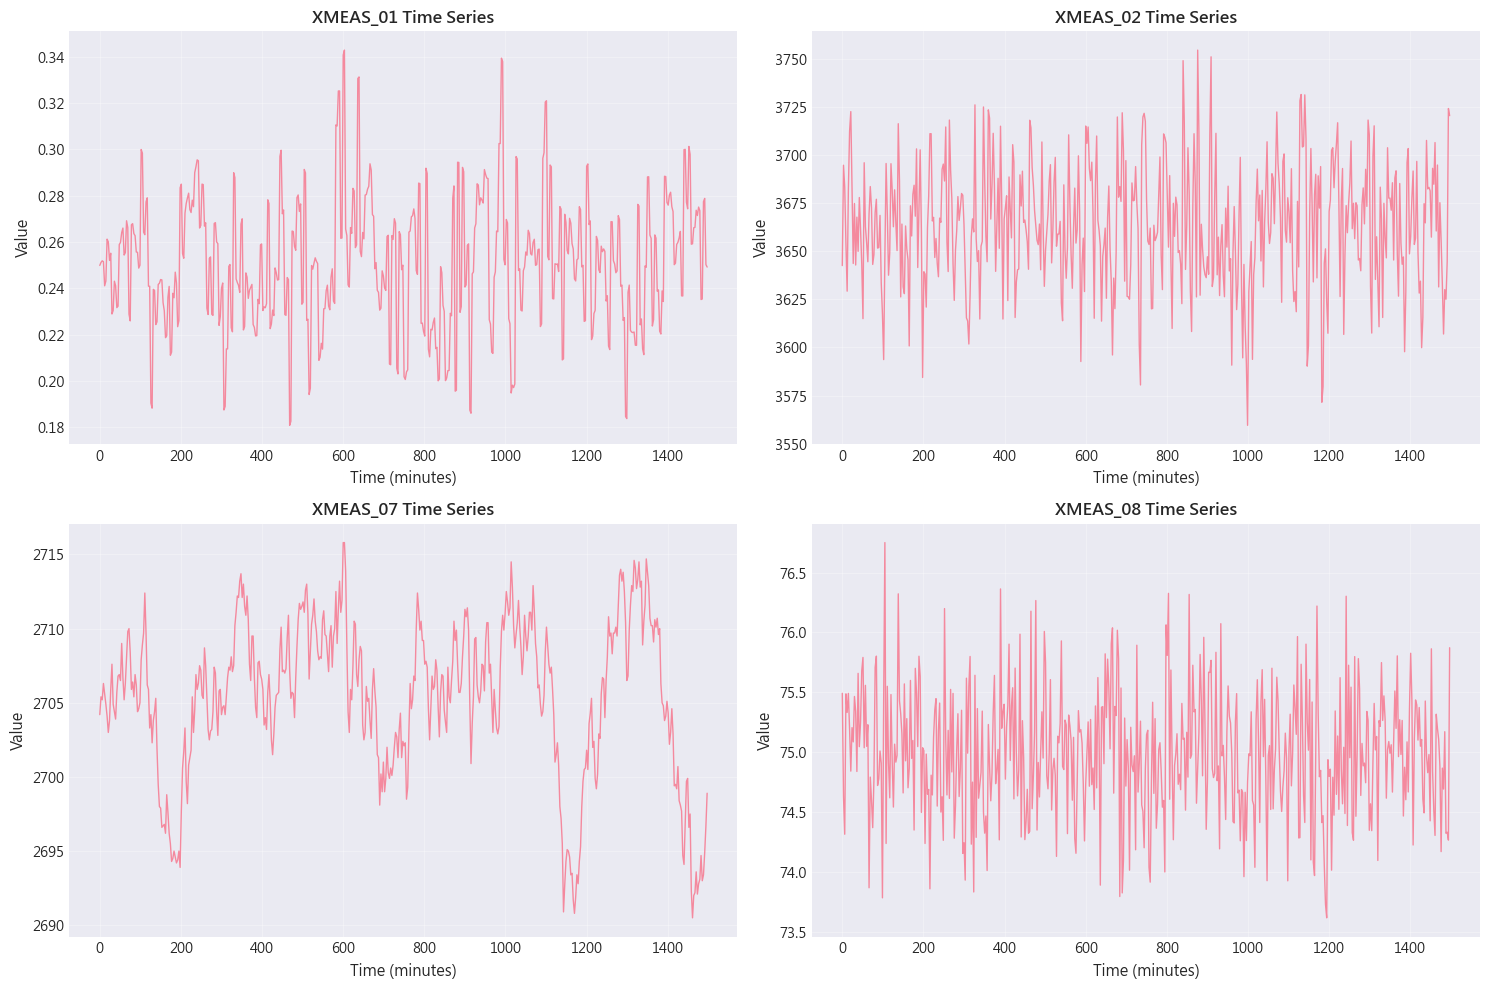


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\key_variables_timeseries.png


In [5]:
# 計算基本統計摘要
print("=" * 70)
print("數據統計摘要")
print("=" * 70)
stats_summary = df_train.describe()
print(stats_summary.iloc[:, :5])  # 顯示前 5 個變數

# 檢查缺失值
missing_count = df_train.isnull().sum().sum()
print(f"\n✓ 總缺失值: {missing_count}")

# 繪製部分關鍵變數的時間序列圖
key_vars = ['XMEAS_01', 'XMEAS_02', 'XMEAS_07', 'XMEAS_08']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, var in enumerate(key_vars):
    axes[idx].plot(df_train.index, df_train[var], linewidth=1, alpha=0.8)
    axes[idx].set_xlabel('Time (minutes)', fontsize=11)
    axes[idx].set_ylabel('Value', fontsize=11)
    axes[idx].set_title(f'{var} Time Series', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'key_variables_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'key_variables_timeseries.png'}")

---
## 2. 數據預處理與標準化

### 2.1 特徵標準化

由於不同變數的量綱和數值範圍差異很大，我們需要進行標準化處理，使所有特徵具有相同的尺度。

In [6]:
# 定義特徵列名 (所有 52 個 TEP 變數)
feature_cols = df_train.columns.tolist()  # XMEAS_01 到 XMEAS_41 + XMV_01 到 XMV_11

print(f"特徵數量: {len(feature_cols)}")
print(f"特徵列表前 10 個: {feature_cols[:10]}")

# 標準化特徵數據
scaler = StandardScaler()

# 擬合並轉換訓練數據
X_train = df_train[feature_cols].values
X_train_scaled = scaler.fit_transform(X_train)

# 轉換測試數據 (使用訓練數據的統計量)
X_test = df_test[feature_cols].values
X_test_scaled = scaler.transform(X_test)

# 轉換為 DataFrame 以便後續分析
df_train_scaled = df_train.copy()
df_train_scaled[feature_cols] = X_train_scaled

df_test_scaled = df_test.copy()
df_test_scaled[feature_cols] = X_test_scaled

print("\n✓ 數據標準化完成")
print(f"訓練數據形狀: {X_train_scaled.shape}")
print(f"測試數據形狀: {X_test_scaled.shape}")
print(f"\n標準化後的數據均值 (應接近 0):")
print(f"訓練數據均值: {X_train_scaled.mean(axis=0)[:5]}")  # 顯示前 5 個變數
print(f"\n標準化後的數據標準差 (應接近 1):")
print(f"訓練數據標準差: {X_train_scaled.std(axis=0)[:5]}")  # 顯示前 5 個變數

特徵數量: 52
特徵列表前 10 個: ['XMEAS_01', 'XMEAS_02', 'XMEAS_03', 'XMEAS_04', 'XMEAS_05', 'XMEAS_06', 'XMEAS_07', 'XMEAS_08', 'XMEAS_09', 'XMEAS_10']

✓ 數據標準化完成
訓練數據形狀: (500, 52)
測試數據形狀: (960, 52)

標準化後的數據均值 (應接近 0):
訓練數據均值: [-2.94875235e-16  1.22266641e-14 -7.36832817e-15 -1.76143544e-14
 -7.40030259e-15]

標準化後的數據標準差 (應接近 1):
訓練數據標準差: [1. 1. 1. 1. 1.]


---
## 3. 完整分析工作流程架構

本節展示TEP數據分析的完整工作流程架構。由於完整實作內容較長，此處提供**工作流程框架**和**關鍵程式碼範例**，學生可參考 Unit05-Unit07 的詳細教學進行各階段的實作。

### 3.1 工作流程總覽

```
階段 1：數據準備與探索 (已完成) ✓
   ├─ 數據載入
   ├─ 基本統計分析
   └─ 數據標準化

階段 2：降維分析
   ├─ PCA 降維與解釋
   ├─ t-SNE 視覺化
   └─ UMAP 視覺化

階段 3：分群分析
   ├─ K-Means 分群
   ├─ Hierarchical 分群
   ├─ DBSCAN 分群
   └─ GMM 分群

階段 4：異常檢測
   ├─ Isolation Forest
   ├─ One-Class SVM
   ├─ LOF
   └─ Elliptic Envelope

階段 5：結果整合與洞察
   ├─ 多方法結果比較
   ├─ 關鍵變數識別
   └─ 工程建議提出
```

### 3.2 階段 2：降維分析 - PCA 範例

以下展示如何應用 PCA 進行降維分析，包含 Scree Plot 和前兩個主成分的視覺化。

PCA 降維結果
原始維度: 52
降維後維度: 36
累積解釋變異數: 95.59%

前 10 個主成分的解釋變異數比例:
  PC1: 12.71%
  PC2: 7.56%
  PC3: 5.40%
  PC4: 4.48%
  PC5: 4.22%
  PC6: 4.01%
  PC7: 3.72%
  PC8: 3.34%
  PC9: 3.13%
  PC10: 2.89%


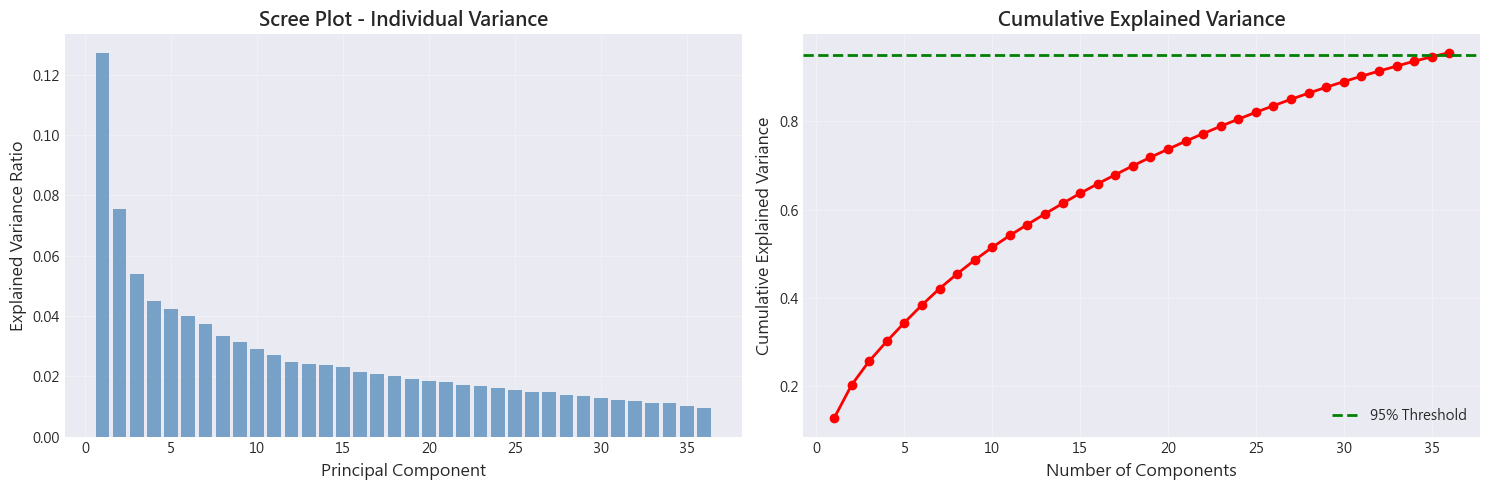


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\pca_scree_plot.png


In [7]:
# ============================================================
# 階段 2：降維分析 - PCA 範例
# ============================================================

# 建立 PCA 模型 (保留 95% 的變異數)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 顯示結果
print("=" * 70)
print("PCA 降維結果")
print("=" * 70)
print(f"原始維度: {X_train_scaled.shape[1]}")
print(f"降維後維度: {X_train_pca.shape[1]}")
print(f"累積解釋變異數: {pca.explained_variance_ratio_.sum():.2%}")
print(f"\n前 10 個主成分的解釋變異數比例:")
for i, ratio in enumerate(pca.explained_variance_ratio_[:10], 1):
    print(f"  PC{i}: {ratio:.2%}")

# 繪製 Scree Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 個別解釋變異數
axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot - Individual Variance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 累積解釋變異數
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 
             'ro-', linewidth=2, markersize=6)
axes[1].axhline(y=0.95, color='g', linestyle='--', linewidth=2, label='95% Threshold')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'pca_scree_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'pca_scree_plot.png'}")

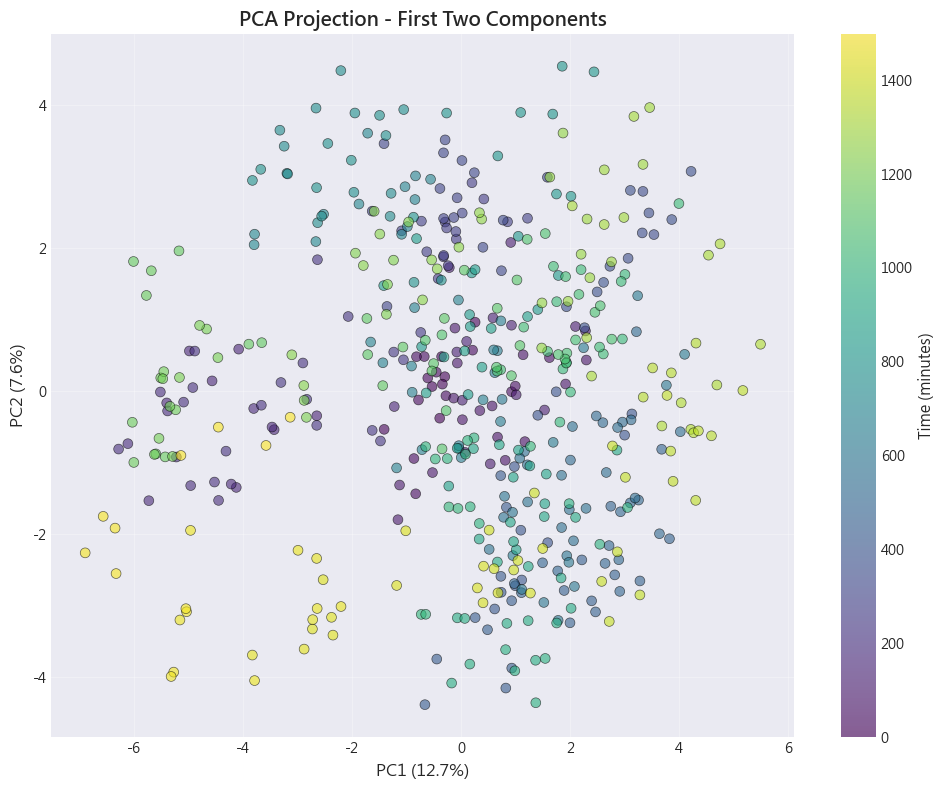

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\pca_scatter_2d.png


In [8]:
# 使用前 2 個主成分繪製散點圖
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                     c=df_train.index, cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='k', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.set_title('PCA Projection - First Two Components', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# 添加顏色條
cbar = plt.colorbar(scatter, ax=ax, label='Time (minutes)')
cbar.set_label('Time (minutes)', fontsize=11)

plt.tight_layout()
plt.savefig(FIG_DIR / 'pca_scatter_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存至: {FIG_DIR / 'pca_scatter_2d.png'}")

### 3.3 階段 3：分群分析 - K-Means 範例

在降維空間中應用 K-Means 分群，使用 Elbow Method 確定最佳群數。

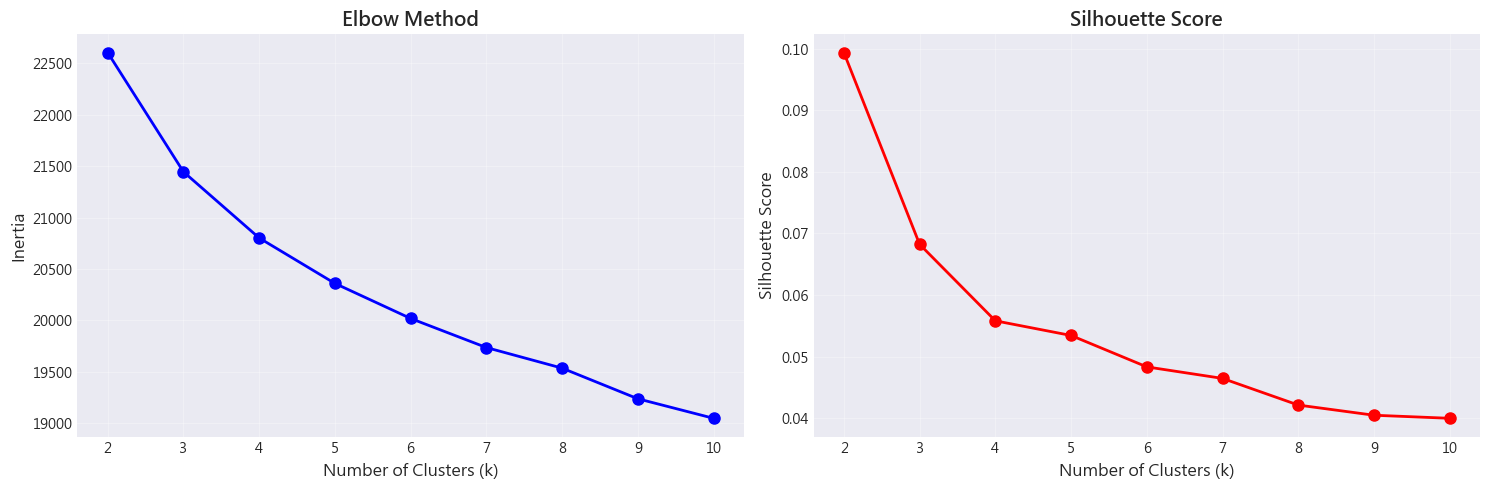


✓ 最佳群數選擇: k = 3
✓ Silhouette Score: 0.068

各群組樣本數:
  Cluster 0: 99 samples
  Cluster 1: 223 samples
  Cluster 2: 178 samples

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\kmeans_optimal_k.png


In [9]:
# ============================================================
# 階段 3：分群分析 - K-Means 範例
# ============================================================

# 使用 Elbow Method 確定最佳群數
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_pca, labels))

# 繪製 Elbow Plot 和 Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kmeans_optimal_k.png', dpi=300, bbox_inches='tight')
plt.show()

# 根據結果選擇最佳 k (假設選擇 k=3)
best_k = 3
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_train = kmeans_best.fit_predict(X_train_pca)

print(f"\n✓ 最佳群數選擇: k = {best_k}")
print(f"✓ Silhouette Score: {silhouette_score(X_train_pca, labels_train):.3f}")
print(f"\n各群組樣本數:")
for i in range(best_k):
    print(f"  Cluster {i}: {np.sum(labels_train == i)} samples")

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'kmeans_optimal_k.png'}")

K-Means 參數影響分析：不同 k 值比較


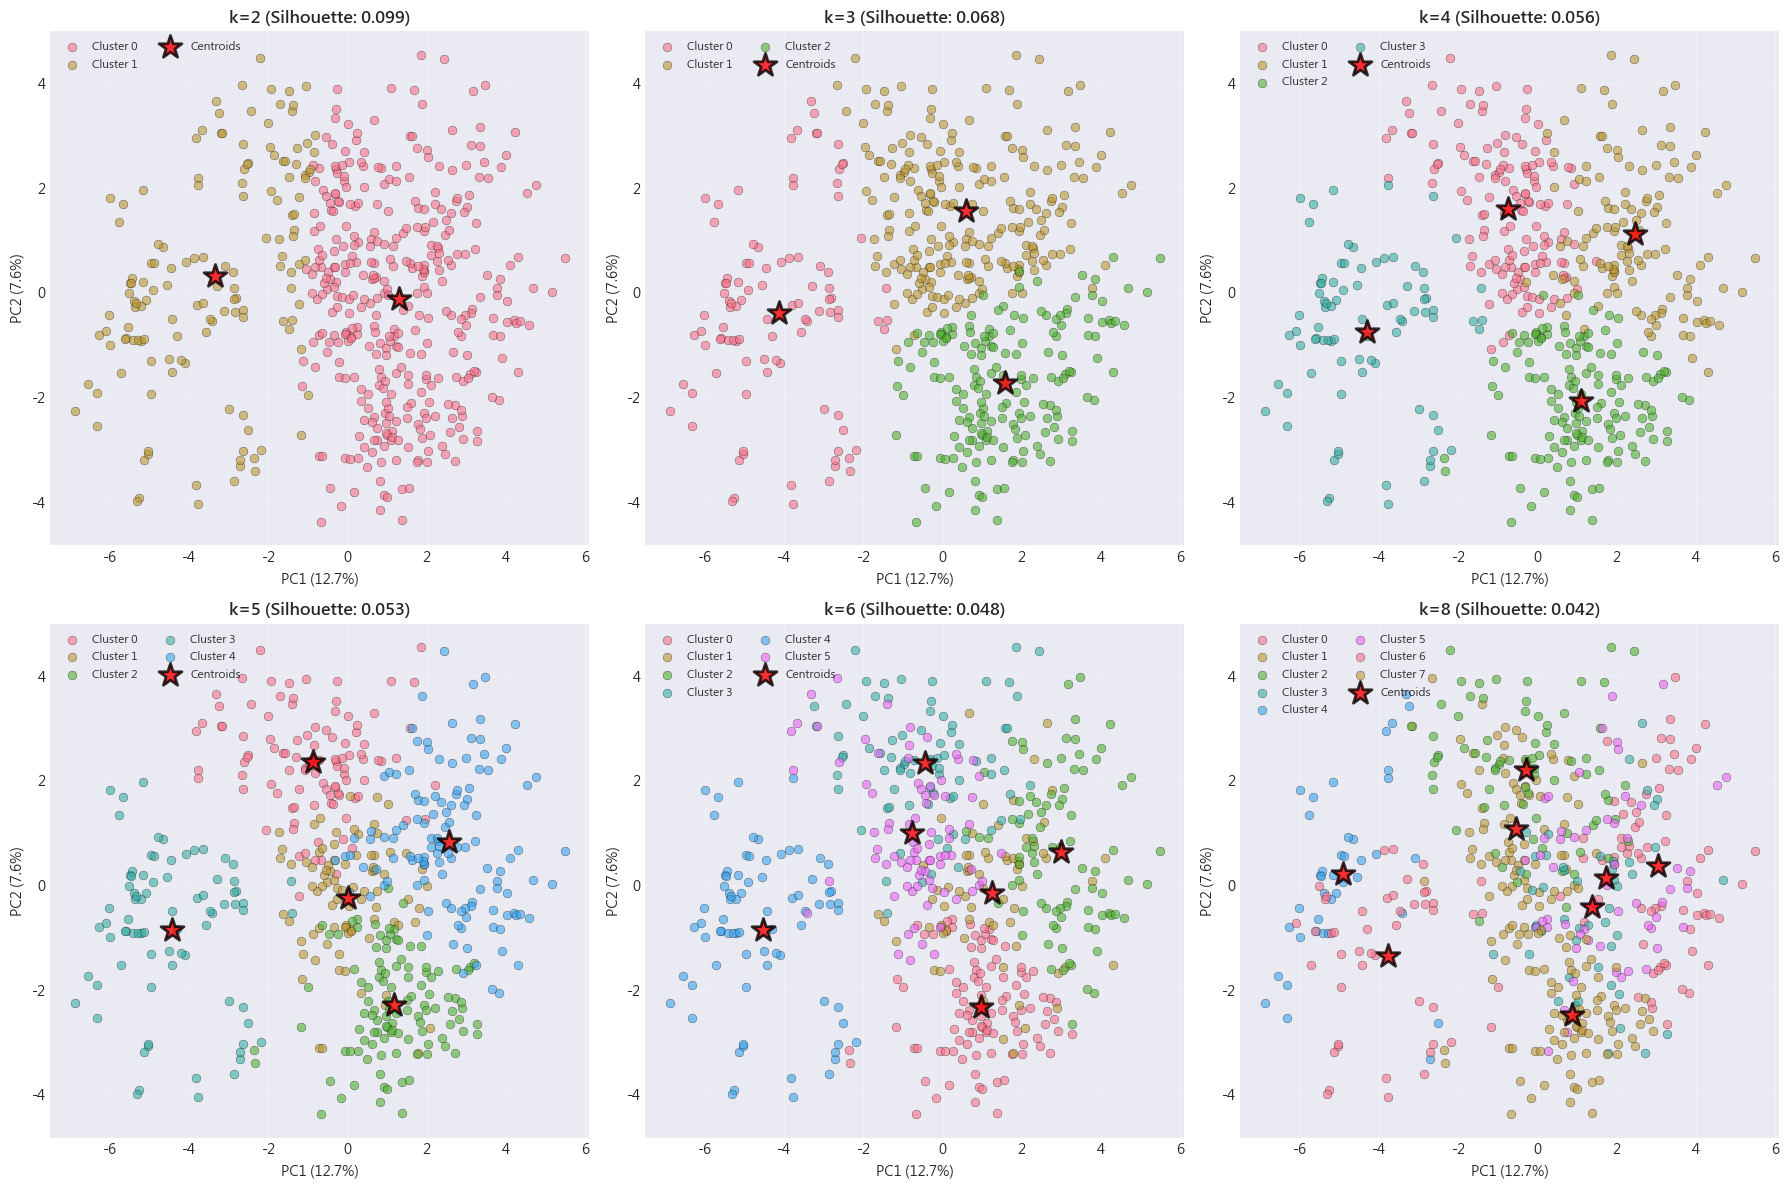


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\kmeans_k_comparison.png

觀察要點:
  1. k 太小 (k=2)：可能過度簡化數據結構，損失細節
  2. k=3：在本案例中達到較好平衡（Silhouette Score 最高）
  3. k 太大 (k=6, 8)：過度分割，產生不必要的小聚類
  4. Silhouette Score 可幫助量化聚類品質

💡 學習重點：選擇 k 值需要在「簡化程度」與「細節保留」之間取得平衡


In [10]:
# ============================================================
# 參數影響分析：不同 k 值的視覺化比較
# ============================================================

print("=" * 70)
print("K-Means 參數影響分析：不同 k 值比較")
print("=" * 70)

# 測試不同的 k 值
k_values = [2, 3, 4, 5, 6, 8]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    # 訓練 K-Means
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_train_pca)
    centers_temp = kmeans_temp.cluster_centers_
    
    # 計算 Silhouette Score
    score_temp = silhouette_score(X_train_pca, labels_temp)
    
    # 繪製聚類結果
    for cluster_id in range(k):
        mask = labels_temp == cluster_id
        axes[idx].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                         s=40, alpha=0.6, edgecolors='k', linewidth=0.3,
                         label=f'Cluster {cluster_id}')
    
    # 繪製質心
    axes[idx].scatter(centers_temp[:, 0], centers_temp[:, 1], 
                     c='red', s=300, alpha=0.8, marker='*', 
                     edgecolors='black', linewidth=2, label='Centroids')
    
    axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=10)
    axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=10)
    axes[idx].set_title(f'k={k} (Silhouette: {score_temp:.3f})', 
                       fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=8, loc='best', ncol=2)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kmeans_k_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'kmeans_k_comparison.png'}")
print("\n觀察要點:")
print("  1. k 太小 (k=2)：可能過度簡化數據結構，損失細節")
print("  2. k=3：在本案例中達到較好平衡（Silhouette Score 最高）")
print("  3. k 太大 (k=6, 8)：過度分割，產生不必要的小聚類")
print("  4. Silhouette Score 可幫助量化聚類品質")
print("\n💡 學習重點：選擇 k 值需要在「簡化程度」與「細節保留」之間取得平衡")

#### 📊 深入理解：K-Means 參數影響分析

讓我們通過視覺化來理解 **不同 k 值** 對聚類結果的影響，這有助於理解為何選擇 k=3。

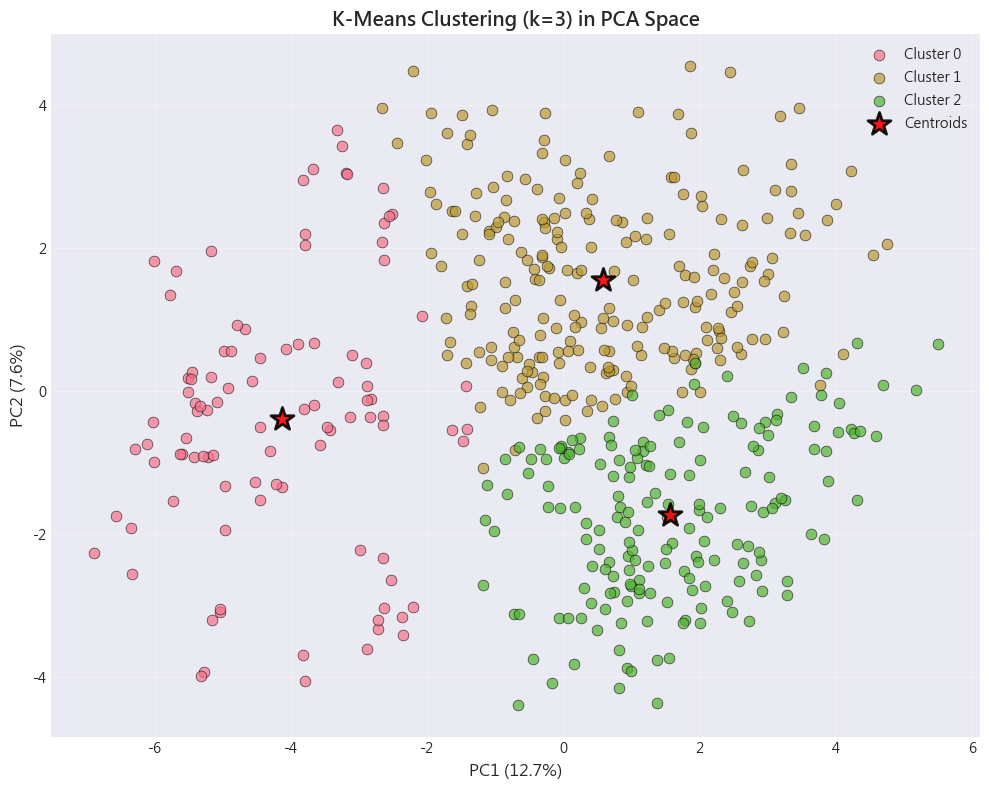

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\kmeans_clusters_pca.png


In [11]:
# 在 PCA 空間中視覺化分群結果
fig, ax = plt.subplots(figsize=(10, 8))

# 繪製各群組的數據點
for cluster_id in range(best_k):
    mask = labels_train == cluster_id
    ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
               label=f'Cluster {cluster_id}', s=60, alpha=0.7, edgecolors='k', linewidth=0.5)

# 繪製群心
centers = kmeans_best.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], 
           c='red', s=300, alpha=0.9, edgecolors='black', linewidth=2, 
           marker='*', label='Centroids')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.set_title(f'K-Means Clustering (k={best_k}) in PCA Space', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'kmeans_clusters_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存至: {FIG_DIR / 'kmeans_clusters_pca.png'}")

### 3.4 階段 4：異常檢測 - Isolation Forest 範例

使用 Isolation Forest 進行異常檢測，識別製程中的異常操作點。

Isolation Forest 異常檢測結果
訓練數據異常比例: 5.00%
測試數據異常比例: 20.00%


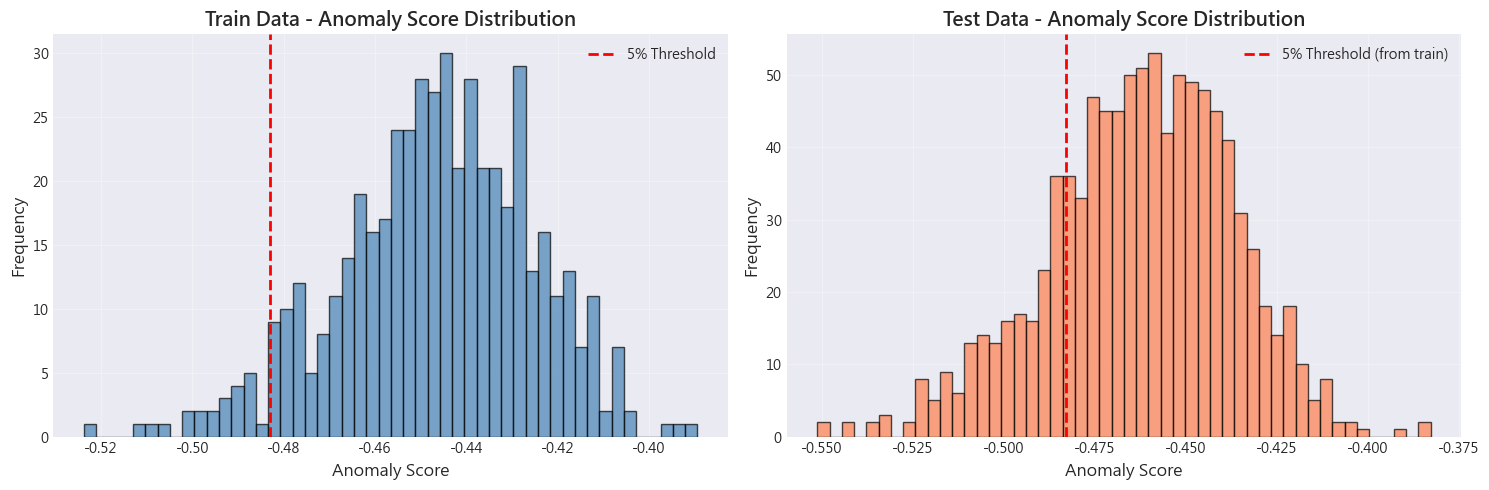


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\isolation_forest_scores.png


In [12]:
# ============================================================
# 階段 4：異常檢測 - Isolation Forest 範例
# ============================================================

# 建立 Isolation Forest 模型
iso_forest = IsolationForest(
    contamination=0.05,  # 預期異常比例為 5%
    random_state=42,
    n_estimators=200  # 增加樹數量以提高穩定性
)

# 訓練模型
iso_forest.fit(X_train_scaled)

# 預測 (1 = 正常, -1 = 異常)
train_pred = iso_forest.predict(X_train_scaled)
test_pred = iso_forest.predict(X_test_scaled)

# 計算異常分數 (分數越低越異常)
train_scores = iso_forest.score_samples(X_train_scaled)
test_scores = iso_forest.score_samples(X_test_scaled)

print("=" * 70)
print("Isolation Forest 異常檢測結果")
print("=" * 70)
print(f"訓練數據異常比例: {np.sum(train_pred == -1) / len(train_pred):.2%}")
print(f"測試數據異常比例: {np.sum(test_pred == -1) / len(test_pred):.2%}")

# 繪製異常分數分布
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 訓練數據異常分數分布
axes[0].hist(train_scores, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=np.percentile(train_scores, 5), color='r', linestyle='--', 
                linewidth=2, label='5% Threshold')
axes[0].set_xlabel('Anomaly Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Train Data - Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 測試數據異常分數分布
axes[1].hist(test_scores, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[1].axvline(x=np.percentile(train_scores, 5), color='r', linestyle='--', 
                linewidth=2, label='5% Threshold (from train)')
axes[1].set_xlabel('Anomaly Score', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Test Data - Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'isolation_forest_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'isolation_forest_scores.png'}")

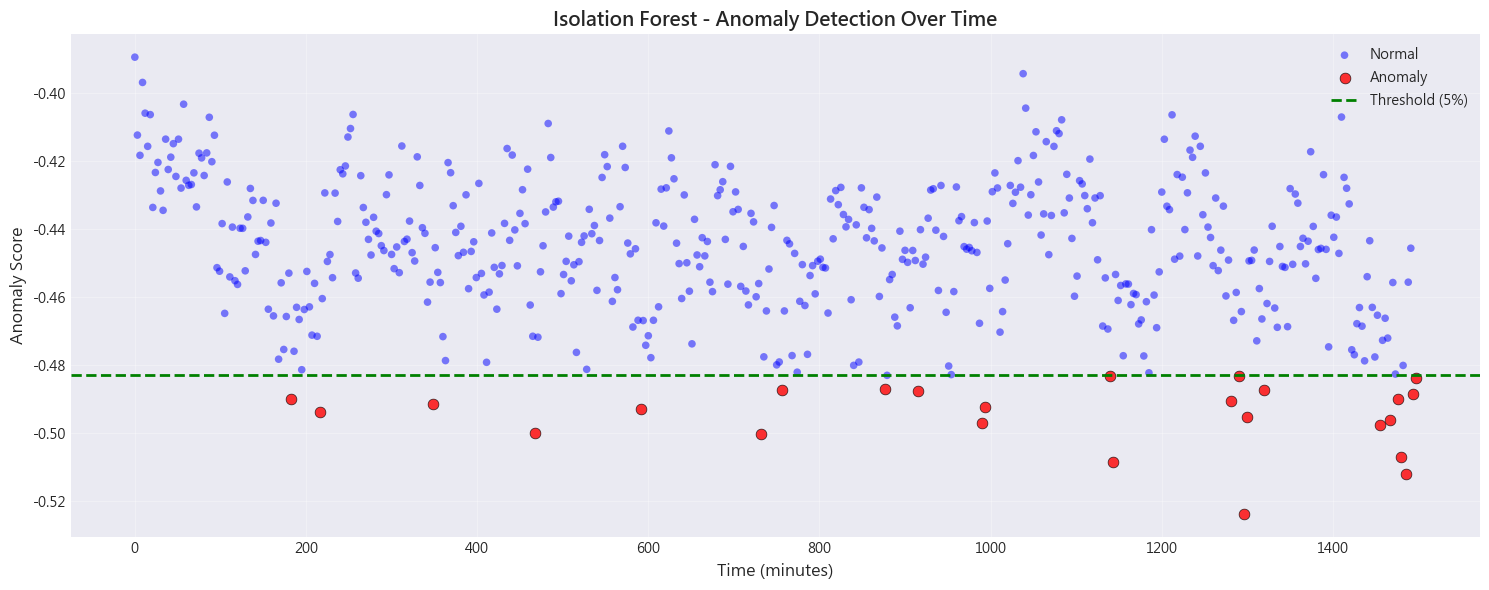

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\anomaly_detection_timeseries.png


In [13]:
# 繪製時間序列中的異常點
fig, ax = plt.subplots(figsize=(15, 6))

# 繪製正常點
normal_mask = train_pred == 1
ax.scatter(df_train.index[normal_mask], train_scores[normal_mask], 
           c='blue', s=30, alpha=0.5, label='Normal', edgecolors='none')

# 繪製異常點
anomaly_mask = train_pred == -1
ax.scatter(df_train.index[anomaly_mask], train_scores[anomaly_mask], 
           c='red', s=60, alpha=0.8, label='Anomaly', edgecolors='black', linewidth=0.5)

# 添加閾值線
threshold = np.percentile(train_scores, 5)
ax.axhline(y=threshold, color='green', linestyle='--', linewidth=2, label='Threshold (5%)')

ax.set_xlabel('Time (minutes)', fontsize=12)
ax.set_ylabel('Anomaly Score', fontsize=12)
ax.set_title('Isolation Forest - Anomaly Detection Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'anomaly_detection_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存至: {FIG_DIR / 'anomaly_detection_timeseries.png'}")

### 3.5 階段 5：結果整合與洞察

整合降維、分群、異常檢測的結果，進行綜合分析：

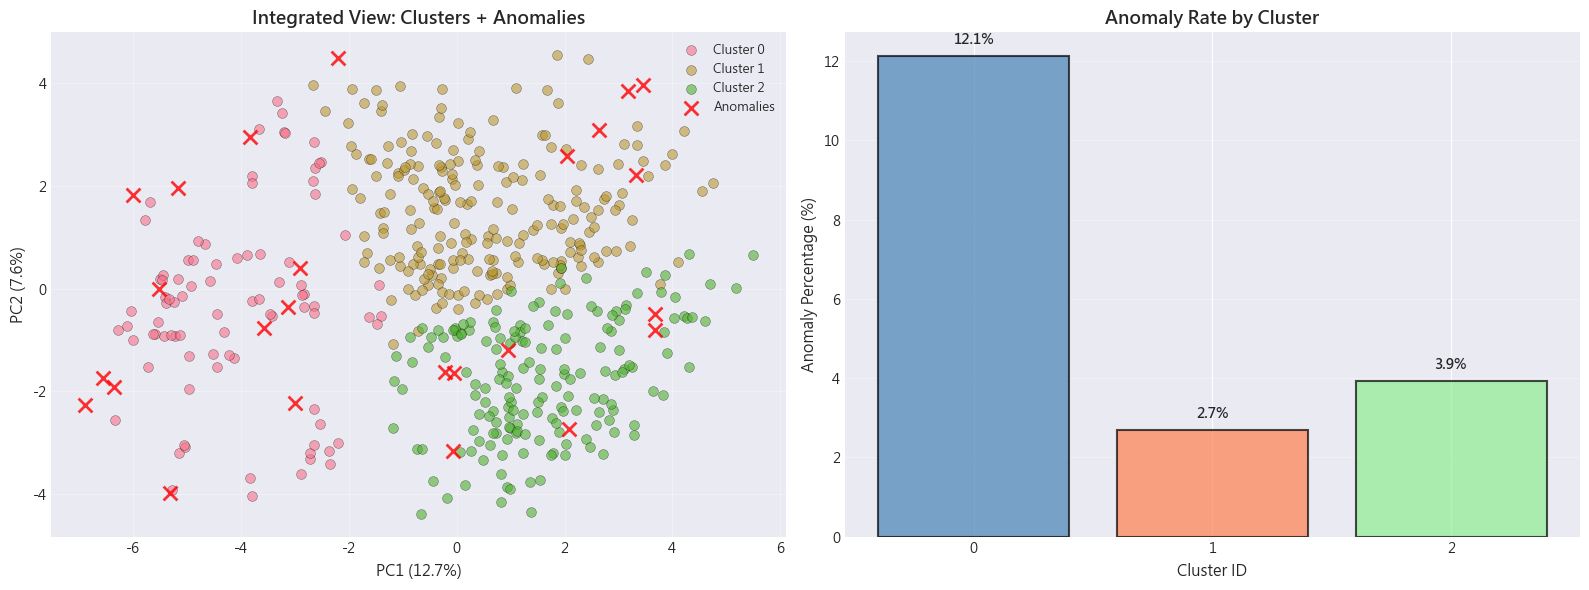

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\integrated_analysis.png

綜合分析摘要

1. 降維結果:
   - 使用 36 個主成分保留 95.6% 變異數

2. 分群結果:
   - 最佳群數: 3
   - Silhouette Score: 0.068
   - Cluster 0: 99 samples (19.8%)
   - Cluster 1: 223 samples (44.6%)
   - Cluster 2: 178 samples (35.6%)

3. 異常檢測結果:
   - 訓練數據異常比例: 5.00%
   - 測試數據異常比例: 20.00%

4. 整合洞察:
   - Cluster 0 異常率: 12.12%
   - Cluster 1 異常率: 2.69%
   - Cluster 2 異常率: 3.93%


In [14]:
# 整合分群與異常檢測結果
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：分群結果 + 異常點標記
for cluster_id in range(best_k):
    mask = (labels_train == cluster_id) & (train_pred == 1)
    axes[0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                    label=f'Cluster {cluster_id}', s=50, alpha=0.6, edgecolors='k', linewidth=0.3)

# 標記異常點
anomaly_mask = train_pred == -1
axes[0].scatter(X_train_pca[anomaly_mask, 0], X_train_pca[anomaly_mask, 1], 
                c='red', s=100, alpha=0.8, marker='x', linewidth=2, label='Anomalies')

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title('Integrated View: Clusters + Anomalies', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9, loc='best')
axes[0].grid(True, alpha=0.3)

# 右圖：各群組的異常比例
cluster_anomaly_counts = []
for cluster_id in range(best_k):
    cluster_mask = labels_train == cluster_id
    n_total = cluster_mask.sum()
    n_anomalies = ((labels_train == cluster_id) & (train_pred == -1)).sum()
    cluster_anomaly_counts.append(n_anomalies / n_total * 100)

axes[1].bar(range(best_k), cluster_anomaly_counts, color=['steelblue', 'coral', 'lightgreen'][:best_k], 
            alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Cluster ID', fontsize=11)
axes[1].set_ylabel('Anomaly Percentage (%)', fontsize=11)
axes[1].set_title('Anomaly Rate by Cluster', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(best_k))
axes[1].grid(True, alpha=0.3, axis='y')

# 在柱狀圖上標註數值
for i, val in enumerate(cluster_anomaly_counts):
    axes[1].text(i, val + 0.3, f'{val:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'integrated_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存至: {FIG_DIR / 'integrated_analysis.png'}")

# 打印分析摘要
print("\n" + "=" * 70)
print("綜合分析摘要")
print("=" * 70)
print(f"\n1. 降維結果:")
print(f"   - 使用 {X_train_pca.shape[1]} 個主成分保留 {pca.explained_variance_ratio_.sum():.1%} 變異數")
print(f"\n2. 分群結果:")
print(f"   - 最佳群數: {best_k}")
print(f"   - Silhouette Score: {silhouette_score(X_train_pca, labels_train):.3f}")
for i in range(best_k):
    print(f"   - Cluster {i}: {np.sum(labels_train == i)} samples ({np.sum(labels_train == i)/len(labels_train)*100:.1f}%)")

print(f"\n3. 異常檢測結果:")
print(f"   - 訓練數據異常比例: {np.sum(train_pred == -1) / len(train_pred):.2%}")
print(f"   - 測試數據異常比例: {np.sum(test_pred == -1) / len(test_pred):.2%}")
print(f"\n4. 整合洞察:")
for i in range(best_k):
    print(f"   - Cluster {i} 異常率: {cluster_anomaly_counts[i]:.2f}%")

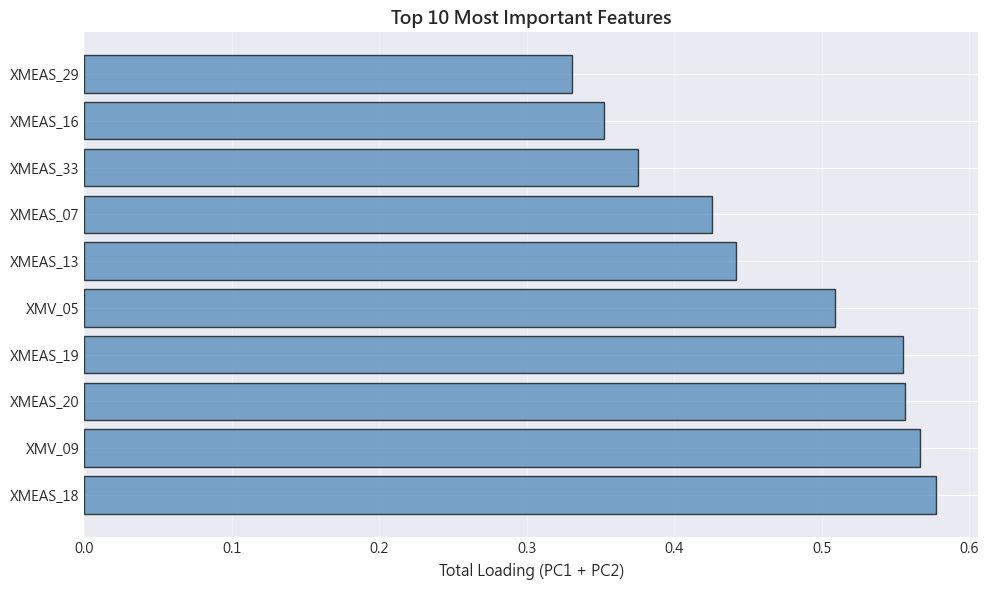

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\feature_importance.png

前 10 個最重要的變數:
  1. XMEAS_18: 0.5775
  2. XMV_09: 0.5665
  3. XMEAS_20: 0.5569
  4. XMEAS_19: 0.5549
  5. XMV_05: 0.5088
  6. XMEAS_13: 0.4419
  7. XMEAS_07: 0.4259
  8. XMEAS_33: 0.3752
  9. XMEAS_16: 0.3526
  10. XMEAS_29: 0.3309


In [15]:
# 識別最重要的特徵變數（基於 PCA loading）
# 計算每個變數在前兩個主成分中的貢獻度
pc1_loading = np.abs(pca.components_[0])
pc2_loading = np.abs(pca.components_[1])
total_loading = pc1_loading + pc2_loading

# 找出前 10 個最重要的變數
top_10_idx = np.argsort(total_loading)[-10:][::-1]
top_10_features = [feature_cols[i] for i in top_10_idx]
top_10_loadings = total_loading[top_10_idx]

# 繪製特徵重要性
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(top_10_features)), top_10_loadings, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_10_features)))
ax.set_yticklabels(top_10_features, fontsize=10)
ax.set_xlabel('Total Loading (PC1 + PC2)', fontsize=11)
ax.set_title('Top 10 Most Important Features', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存至: {FIG_DIR / 'feature_importance.png'}")
print(f"\n前 10 個最重要的變數:")
for i, (feat, loading) in enumerate(zip(top_10_features, top_10_loadings), 1):
    print(f"  {i}. {feat}: {loading:.4f}")

---
## 4. 進階實作：多方法比較與故障診斷

在前面的章節中，我們展示了 PCA、K-Means、Isolation Forest 的基本應用。本節將完整實作**其他降維方法**、**其他分群方法**、**其他異常檢測方法**，並進行**多方法比較**與**故障場景分析**，讓這成為一個真正完整的綜合案例研究。

### 4.1 其他降維方法比較：t-SNE 與 UMAP

除了 PCA，我們還可以使用 t-SNE 和 UMAP 等非線性降維方法，比較不同方法在 TEP 數據上的視覺化效果。

多種降維方法比較

⏳ 正在執行 t-SNE 降維（預計耗時 2-5 分鐘）...
💡 提示：t-SNE 計算密集，建議先使用小樣本測試參數
✓ t-SNE 完成（耗時: 1.71 秒）

⏳ 正在執行 UMAP 降維（預計耗時 30-60 秒）...
✓ UMAP 完成（耗時: 11.39 秒）


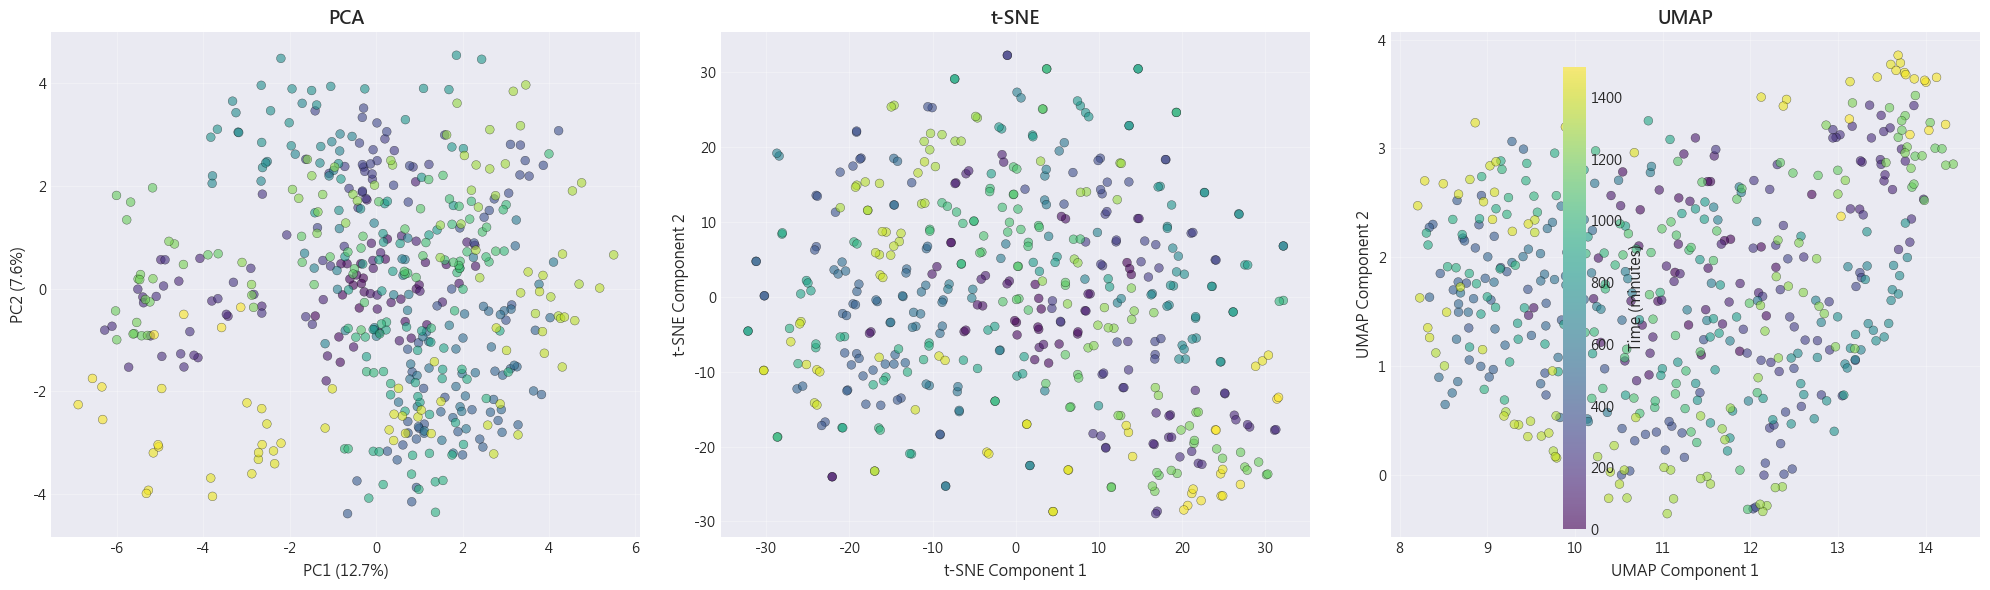


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\dimensionality_reduction_comparison.png

降維方法比較:
  - PCA: 線性降維，保留最大變異數，可解釋性強
  - t-SNE: 非線性降維，保留局部結構，適合視覺化
  - UMAP: 非線性降維，保留全局和局部結構，速度較快


In [16]:
# ============================================================
# 4.1 其他降維方法：t-SNE 和 UMAP
# ============================================================

print("=" * 70)
print("多種降維方法比較")
print("=" * 70)

# t-SNE 降維
print("\n⏳ 正在執行 t-SNE 降維（預計耗時 2-5 分鐘）...")
print("💡 提示：t-SNE 計算密集，建議先使用小樣本測試參數")
import time
start_time = time.time()

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_train_tsne = tsne.fit_transform(X_train_scaled)

elapsed_time = time.time() - start_time
print(f"✓ t-SNE 完成（耗時: {elapsed_time:.2f} 秒）")

# UMAP 降維
print("\n⏳ 正在執行 UMAP 降維（預計耗時 30-60 秒）...")
start_time = time.time()

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_train_umap = umap_model.fit_transform(X_train_scaled)

elapsed_time = time.time() - start_time
print(f"✓ UMAP 完成（耗時: {elapsed_time:.2f} 秒）")

# 比較三種降維方法的視覺化效果
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# PCA
scatter1 = axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                          c=df_train.index, cmap='viridis', 
                          s=40, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title('PCA', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# t-SNE
scatter2 = axes[1].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], 
                          c=df_train.index, cmap='viridis', 
                          s=40, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[1].set_xlabel('t-SNE Component 1', fontsize=11)
axes[1].set_ylabel('t-SNE Component 2', fontsize=11)
axes[1].set_title('t-SNE', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# UMAP
scatter3 = axes[2].scatter(X_train_umap[:, 0], X_train_umap[:, 1], 
                          c=df_train.index, cmap='viridis', 
                          s=40, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[2].set_xlabel('UMAP Component 1', fontsize=11)
axes[2].set_ylabel('UMAP Component 2', fontsize=11)
axes[2].set_title('UMAP', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# 添加共用顏色條
cbar = plt.colorbar(scatter3, ax=axes, label='Time (minutes)', pad=0.02)
cbar.set_label('Time (minutes)', fontsize=11)

plt.tight_layout()
plt.savefig(FIG_DIR / 'dimensionality_reduction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'dimensionality_reduction_comparison.png'}")
print("\n降維方法比較:")
print("  - PCA: 線性降維，保留最大變異數，可解釋性強")
print("  - t-SNE: 非線性降維，保留局部結構，適合視覺化")
print("  - UMAP: 非線性降維，保留全局和局部結構，速度較快")

降維方法距離保留分析

距離保留能力 (Spearman 相關係數):
  PCA:   0.616 (僅前2維)
  t-SNE: 0.553
  UMAP:  0.519


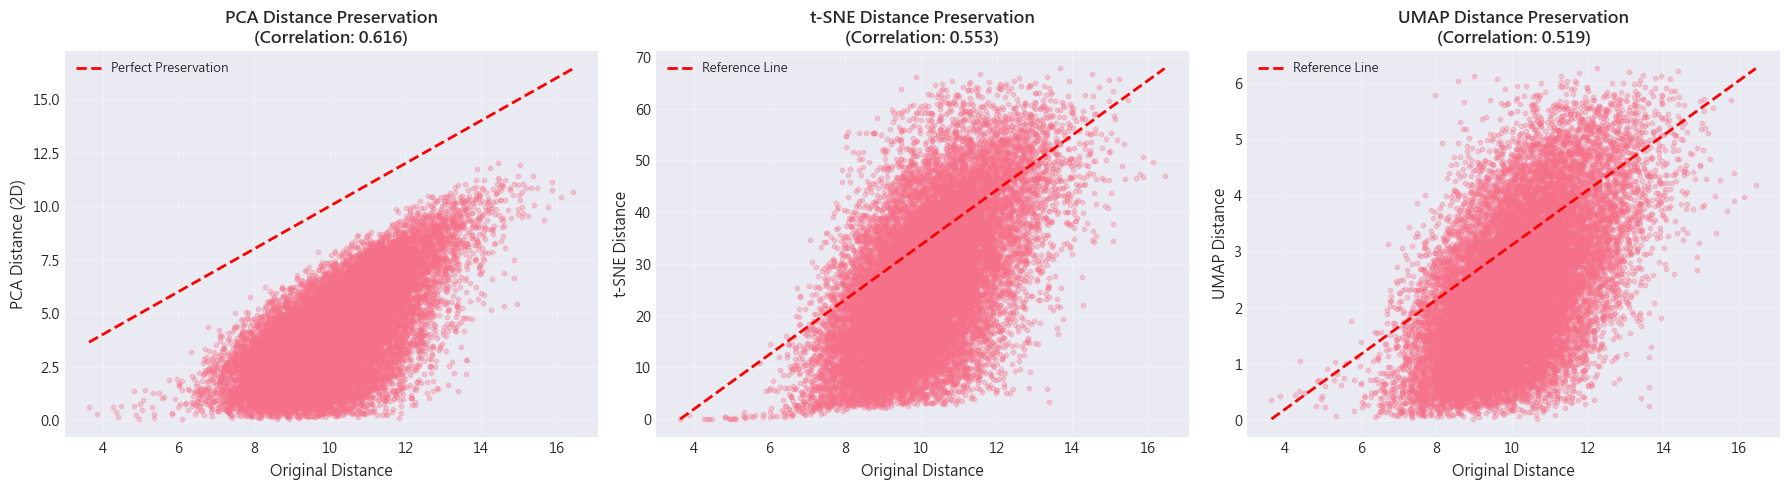


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\distance_preservation_comparison.png

💡 解讀說明:
  • 相關係數越接近 1 → 距離保留越好
  • PCA (2D): 線性降維，保留主要變異方向但損失部分距離信息
  • t-SNE: 專注於保留局部鄰域關係，全局距離可能失真
  • UMAP: 較好地平衡全局與局部結構保留

📌 應用建議:
  → 需要保留距離信息用於後續分析：選擇 PCA (全維度) 或 UMAP
  → 僅用於視覺化探索：t-SNE 和 UMAP 都適合
  → 需要可解釋性：選擇 PCA


In [17]:
# ============================================================
# 降維方法比較：距離保留能力分析
# ============================================================

from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

print("=" * 70)
print("降維方法距離保留分析")
print("=" * 70)

# 隨機抽樣 200 個點以加快計算
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_scaled), 200, replace=False)

X_sample = X_train_scaled[sample_idx]
X_sample_pca = X_train_pca[sample_idx]
X_sample_tsne = X_train_tsne[sample_idx]
X_sample_umap = X_train_umap[sample_idx]

# 計算原始空間的距離矩陣
dist_original = pdist(X_sample, metric='euclidean')

# 計算降維空間的距離矩陣
dist_pca = pdist(X_sample_pca[:, :2], metric='euclidean')
dist_tsne = pdist(X_sample_tsne, metric='euclidean')
dist_umap = pdist(X_sample_umap, metric='euclidean')

# 計算 Spearman 相關係數 (評估距離保留程度)
corr_pca, _ = spearmanr(dist_original, dist_pca)
corr_tsne, _ = spearmanr(dist_original, dist_tsne)
corr_umap, _ = spearmanr(dist_original, dist_umap)

print(f"\n距離保留能力 (Spearman 相關係數):")
print(f"  PCA:   {corr_pca:.3f} (僅前2維)")
print(f"  t-SNE: {corr_tsne:.3f}")
print(f"  UMAP:  {corr_umap:.3f}")

# 視覺化距離關係
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PCA
axes[0].scatter(dist_original, dist_pca, alpha=0.3, s=10)
axes[0].plot([dist_original.min(), dist_original.max()], 
            [dist_original.min(), dist_original.max()], 
            'r--', linewidth=2, label='Perfect Preservation')
axes[0].set_xlabel('Original Distance', fontsize=11)
axes[0].set_ylabel('PCA Distance (2D)', fontsize=11)
axes[0].set_title(f'PCA Distance Preservation\n(Correlation: {corr_pca:.3f})', 
                 fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# t-SNE
axes[1].scatter(dist_original, dist_tsne, alpha=0.3, s=10)
axes[1].plot([dist_original.min(), dist_original.max()], 
            [dist_tsne.min(), dist_tsne.max()], 
            'r--', linewidth=2, label='Reference Line')
axes[1].set_xlabel('Original Distance', fontsize=11)
axes[1].set_ylabel('t-SNE Distance', fontsize=11)
axes[1].set_title(f't-SNE Distance Preservation\n(Correlation: {corr_tsne:.3f})', 
                 fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

# UMAP
axes[2].scatter(dist_original, dist_umap, alpha=0.3, s=10)
axes[2].plot([dist_original.min(), dist_original.max()], 
            [dist_umap.min(), dist_umap.max()], 
            'r--', linewidth=2, label='Reference Line')
axes[2].set_xlabel('Original Distance', fontsize=11)
axes[2].set_ylabel('UMAP Distance', fontsize=11)
axes[2].set_title(f'UMAP Distance Preservation\n(Correlation: {corr_umap:.3f})', 
                 fontsize=12, fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'distance_preservation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'distance_preservation_comparison.png'}")
print("\n💡 解讀說明:")
print("  • 相關係數越接近 1 → 距離保留越好")
print("  • PCA (2D): 線性降維，保留主要變異方向但損失部分距離信息")
print("  • t-SNE: 專注於保留局部鄰域關係，全局距離可能失真")
print("  • UMAP: 較好地平衡全局與局部結構保留")
print("\n📌 應用建議:")
print("  → 需要保留距離信息用於後續分析：選擇 PCA (全維度) 或 UMAP")
print("  → 僅用於視覺化探索：t-SNE 和 UMAP 都適合")
print("  → 需要可解釋性：選擇 PCA")

#### 📊 深入理解：降維方法保留信息的能力比較

讓我們通過**距離保留分析**來理解不同降維方法如何保留數據的結構信息。

### 4.2 其他分群方法比較：Hierarchical、DBSCAN、GMM

除了 K-Means，我們還可以使用階層式分群、密度分群、高斯混合模型等方法，比較不同分群演算法的效果。

#### 📊 深入理解：DBSCAN 參數選擇策略

在應用 DBSCAN 分群演算法時，正確選擇參數至關重要。以下詳細說明參數選擇方法。

**DBSCAN 兩個關鍵參數**：
- **eps (epsilon)**: 鄰域半徑，決定兩點之間被視為鄰居的最大距離
- **min_samples**: 核心點的最小鄰域點數要求

**eps 參數選擇方法 - k-distance 圖法**：
1. 計算每個點到其第 k 近鄰的距離（k = min_samples）
2. 將這些距離按升序排列
3. 繪製 k-distance 圖（點序號 vs 距離）
4. 找出曲線的「肘部」位置，對應的距離值作為 eps

**百分位數選擇經驗**：
- **50th 百分位**: 保守選擇，產生較多小聚類，噪音點較多
- **55th-60th 百分位**: 平衡選擇（**推薦起點**），聚類數適中
- **70th 百分位**: 激進選擇，產生較少大聚類，但可能過度合併

**參數調整方向**：
- eps ↑ → 聚類數 ↓, 噪音點比例 ↓, 聚類更大
- eps ↓ → 聚類數 ↑, 噪音點比例 ↑, 聚類更小
- min_samples ↑ → 聚類數 ↓, 噪音點比例 ↑, 密度要求更高
- min_samples ↓ → 聚類數 ↑, 噪音點比例 ↓, 密度要求更低

**實務建議**：
1. 從第 55 百分位開始測試
2. 觀察聚類數和噪音點比例
3. 根據領域知識調整（化工製程通常期望 2-5% 噪音點）
4. 使用 Silhouette Score 輔助評估聚類品質

多種分群方法比較

1. K-Means (k=3)
   Silhouette Score: 0.068

正在訓練 Hierarchical Clustering...
2. Hierarchical Clustering (k=3)
   Silhouette Score: 0.045

正在訓練 DBSCAN...
💡 使用 k-distance 圖法自動估計 eps 參數...

3. DBSCAN (eps=7.42, min_samples=10)
   發現群數: 1
   噪音點數: 36 (7.2%)
   Silhouette Score: 0.000
   💡 建議嘗試 eps 範圍: 7.37 ~ 7.61

   📊 DBSCAN 參數敏感性測試:
      eps=7.0: 1 clusters, 141 noise (28.2%)
      eps=6.5: 2 clusters, 359 noise (71.8%)
      eps=6.0: 1 clusters, 487 noise (97.4%)
      eps=5.5: 0 clusters, 500 noise (100.0%)
      eps=5.0: 0 clusters, 500 noise (100.0%)

正在訓練 Gaussian Mixture Model...

4. Gaussian Mixture Model (k=3)
   Silhouette Score: 0.067


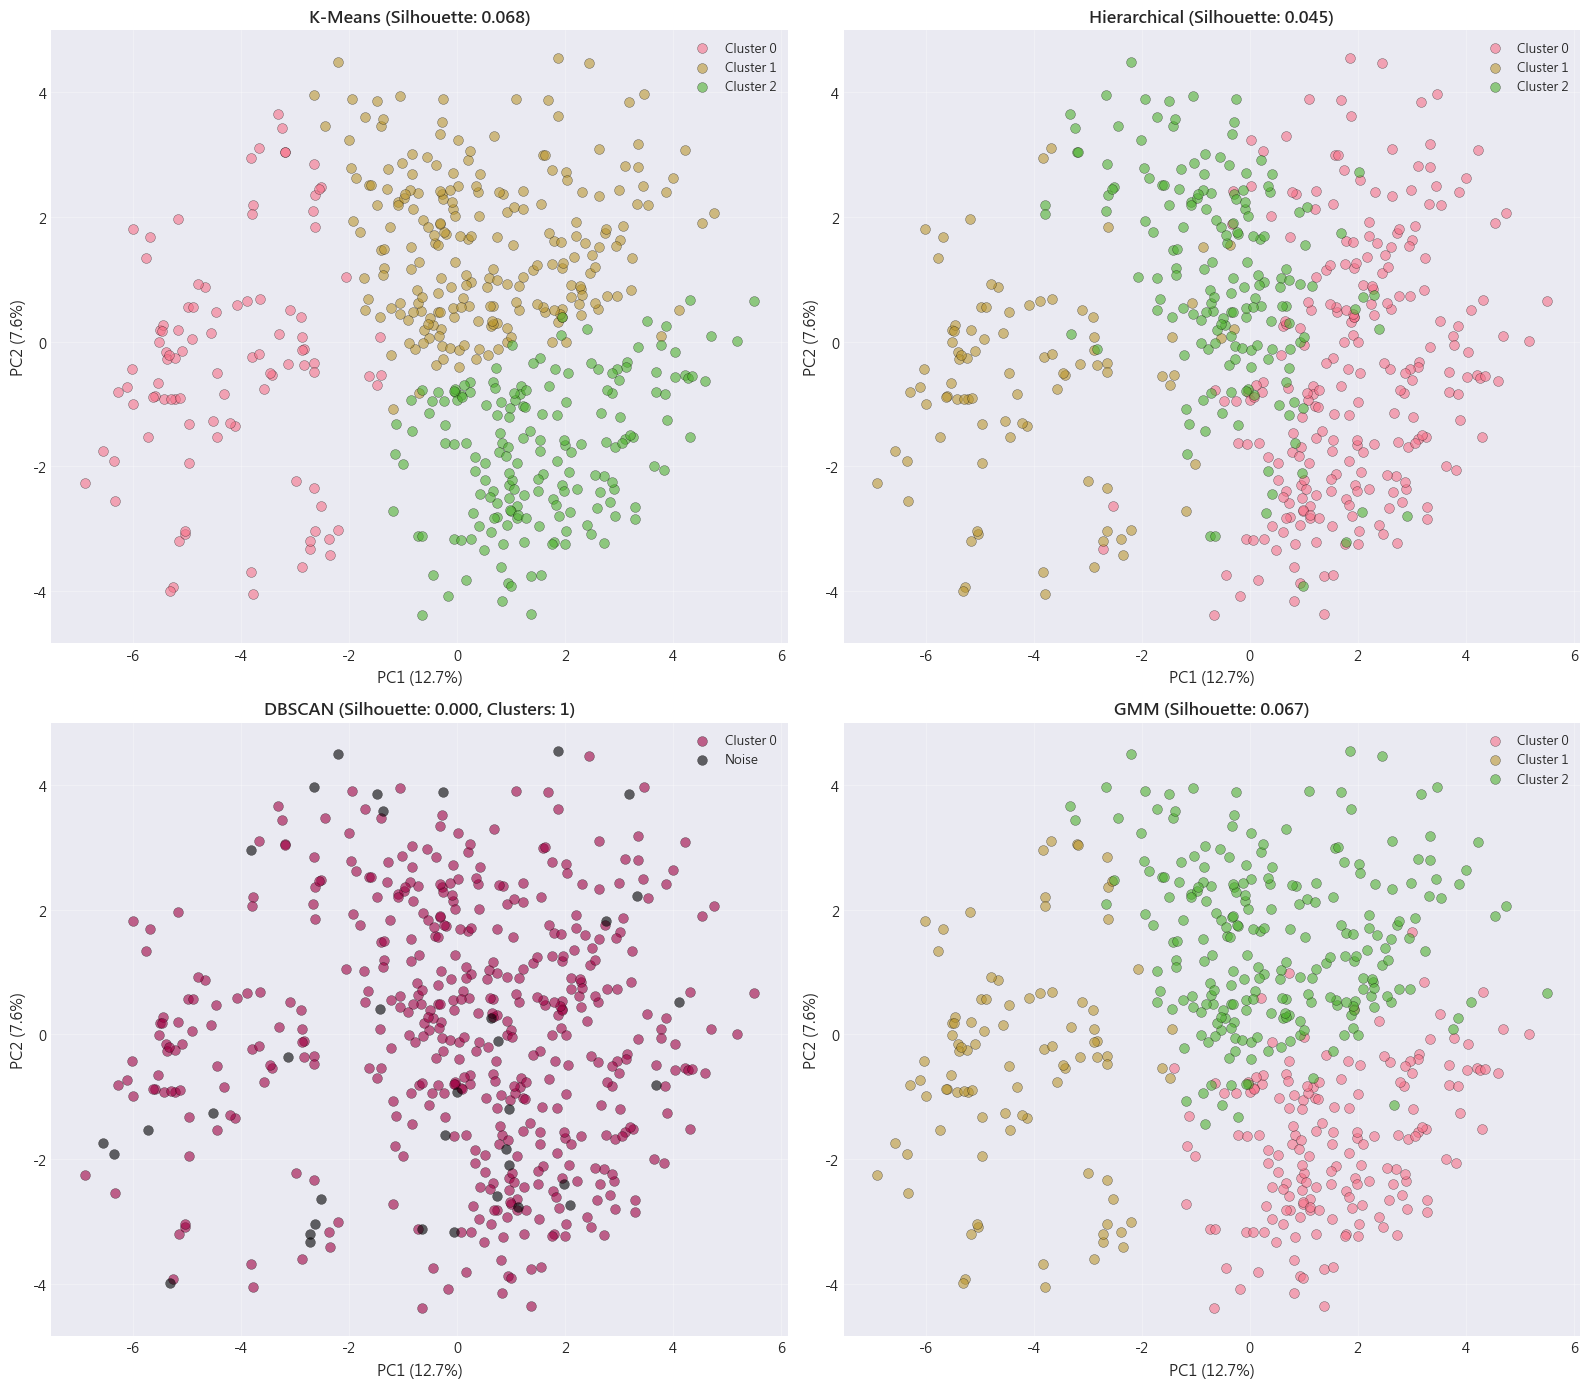


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\clustering_methods_comparison.png

分群方法性能比較
      Method  Silhouette Score  N_Clusters  N_Noise
     K-Means          0.068230           3        0
Hierarchical          0.044925           3        0
      DBSCAN          0.000000           1       36
         GMM          0.067163           3        0


In [18]:
# ============================================================
# 4.2 其他分群方法比較
# ============================================================

print("=" * 70)
print("多種分群方法比較")
print("=" * 70)

# 使用 PCA 降維後的數據進行分群

# 1. K-Means (已完成，使用已有的 labels_train)
labels_kmeans = labels_train
score_kmeans = silhouette_score(X_train_pca, labels_kmeans)
print(f"\n1. K-Means (k={best_k})")
print(f"   Silhouette Score: {score_kmeans:.3f}")

# 2. Hierarchical Clustering (階層式分群)
print("\n正在訓練 Hierarchical Clustering...")
hierarchical = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels_hierarchical = hierarchical.fit_predict(X_train_pca)
score_hierarchical = silhouette_score(X_train_pca, labels_hierarchical)
print(f"2. Hierarchical Clustering (k={best_k})")
print(f"   Silhouette Score: {score_hierarchical:.3f}")

# 3. DBSCAN (密度分群) - 使用 k-distance 圖自動搜尋最佳參數
print("\n正在訓練 DBSCAN...")
print("💡 使用 k-distance 圖法自動估計 eps 參數...")
from sklearn.neighbors import NearestNeighbors

# 設定 min_samples 參數
k = 10  # min_samples 參數

# 計算 k-distance 圖
nbrs = NearestNeighbors(n_neighbors=k).fit(X_train_pca)
distances, indices = nbrs.kneighbors(X_train_pca)
distances = np.sort(distances[:, k-1], axis=0)

# 使用第55百分位作為 eps 參數（平衡聚類數與噪音點比例）
eps_optimal = np.percentile(distances, 55)
# 建議可嘗試的範圍
eps_lower = np.percentile(distances, 50)
eps_upper = np.percentile(distances, 70)

dbscan = DBSCAN(eps=eps_optimal, min_samples=k)
labels_dbscan = dbscan.fit_predict(X_train_pca)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

if n_clusters_dbscan > 1:
    # 排除噪音點計算 silhouette score
    mask_valid = labels_dbscan != -1
    if sum(mask_valid) > 0:
        score_dbscan = silhouette_score(X_train_pca[mask_valid], labels_dbscan[mask_valid])
    else:
        score_dbscan = 0
else:
    score_dbscan = 0

print(f"\n3. DBSCAN (eps={eps_optimal:.2f}, min_samples={k})")
print(f"   發現群數: {n_clusters_dbscan}")
print(f"   噪音點數: {n_noise} ({n_noise/len(X_train_pca)*100:.1f}%)")
print(f"   Silhouette Score: {score_dbscan:.3f}")
print(f"   💡 建議嘗試 eps 範圍: {eps_lower:.2f} ~ {eps_upper:.2f}")

# DBSCAN 參數敏感性測試
print("\n   📊 DBSCAN 參數敏感性測試:")
eps_test_values = [7.0, 6.5, 6.0, 5.5, 5.0]
for eps_val in eps_test_values:
    dbscan_test = DBSCAN(eps=eps_val, min_samples=k)
    labels_test = dbscan_test.fit_predict(X_train_pca)
    n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise_test = list(labels_test).count(-1)
    noise_pct = n_noise_test/len(X_train_pca)*100
    print(f"      eps={eps_val:.1f}: {n_clusters_test} clusters, {n_noise_test} noise ({noise_pct:.1f}%)")

# 4. Gaussian Mixture Model (GMM)
print("\n正在訓練 Gaussian Mixture Model...")
gmm = GaussianMixture(n_components=best_k, random_state=42, covariance_type='full')
labels_gmm = gmm.fit_predict(X_train_pca)
score_gmm = silhouette_score(X_train_pca, labels_gmm)
print(f"\n4. Gaussian Mixture Model (k={best_k})")
print(f"   Silhouette Score: {score_gmm:.3f}")

# 視覺化比較四種分群方法
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

# K-Means
for cluster_id in range(best_k):
    mask = labels_kmeans == cluster_id
    axes[0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                   label=f'Cluster {cluster_id}', s=50, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title(f'K-Means (Silhouette: {score_kmeans:.3f})', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9, loc='best')
axes[0].grid(True, alpha=0.3)

# Hierarchical
for cluster_id in range(best_k):
    mask = labels_hierarchical == cluster_id
    axes[1].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                   label=f'Cluster {cluster_id}', s=50, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1].set_title(f'Hierarchical (Silhouette: {score_hierarchical:.3f})', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9, loc='best')
axes[1].grid(True, alpha=0.3)

# DBSCAN
unique_labels = set(labels_dbscan)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k_label, col in zip(unique_labels, colors):
    if k_label == -1:
        col = [0, 0, 0, 1]  # 黑色表示噪音
        label_name = 'Noise'
    else:
        label_name = f'Cluster {k_label}'
    
    class_member_mask = (labels_dbscan == k_label)
    axes[2].scatter(X_train_pca[class_member_mask, 0], X_train_pca[class_member_mask, 1], 
                   c=[col], label=label_name, s=50, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[2].set_title(f'DBSCAN (Silhouette: {score_dbscan:.3f}, Clusters: {n_clusters_dbscan})', 
                 fontsize=12, fontweight='bold')
axes[2].legend(fontsize=9, loc='best')
axes[2].grid(True, alpha=0.3)

# GMM
for cluster_id in range(best_k):
    mask = labels_gmm == cluster_id
    axes[3].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                   label=f'Cluster {cluster_id}', s=50, alpha=0.6, edgecolors='k', linewidth=0.3)
axes[3].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[3].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[3].set_title(f'GMM (Silhouette: {score_gmm:.3f})', fontsize=12, fontweight='bold')
axes[3].legend(fontsize=9, loc='best')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'clustering_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'clustering_methods_comparison.png'}")

# 性能比較摘要
print("\n" + "=" * 70)
print("分群方法性能比較")
print("=" * 70)
comparison_data = {
    'Method': ['K-Means', 'Hierarchical', 'DBSCAN', 'GMM'],
    'Silhouette Score': [score_kmeans, score_hierarchical, score_dbscan, score_gmm],
    'N_Clusters': [best_k, best_k, n_clusters_dbscan, best_k],
    'N_Noise': [0, 0, n_noise, 0]
}
df_comparison = pd.DataFrame(comparison_data)

print(df_comparison.to_string(index=False))

### 4.3 其他異常檢測方法比較：One-Class SVM、LOF、Elliptic Envelope

除了 Isolation Forest，我們還可以使用 One-Class SVM、LOF、Elliptic Envelope 等方法，比較不同異常檢測演算法的效果。

多種異常檢測方法比較

1. Isolation Forest
   異常比例: 5.00%

⏳ 正在訓練 One-Class SVM（預計耗時 1-3 分鐘）...
💡 提示：One-Class SVM 計算較耗時，特別是大數據集
✓ One-Class SVM 完成（耗時: 0.01 秒）
2. One-Class SVM
   異常比例: 7.40%

正在訓練 Local Outlier Factor...
3. Local Outlier Factor
   異常比例: 5.00%

正在訓練 Elliptic Envelope...
4. Elliptic Envelope
   異常比例: 5.00%


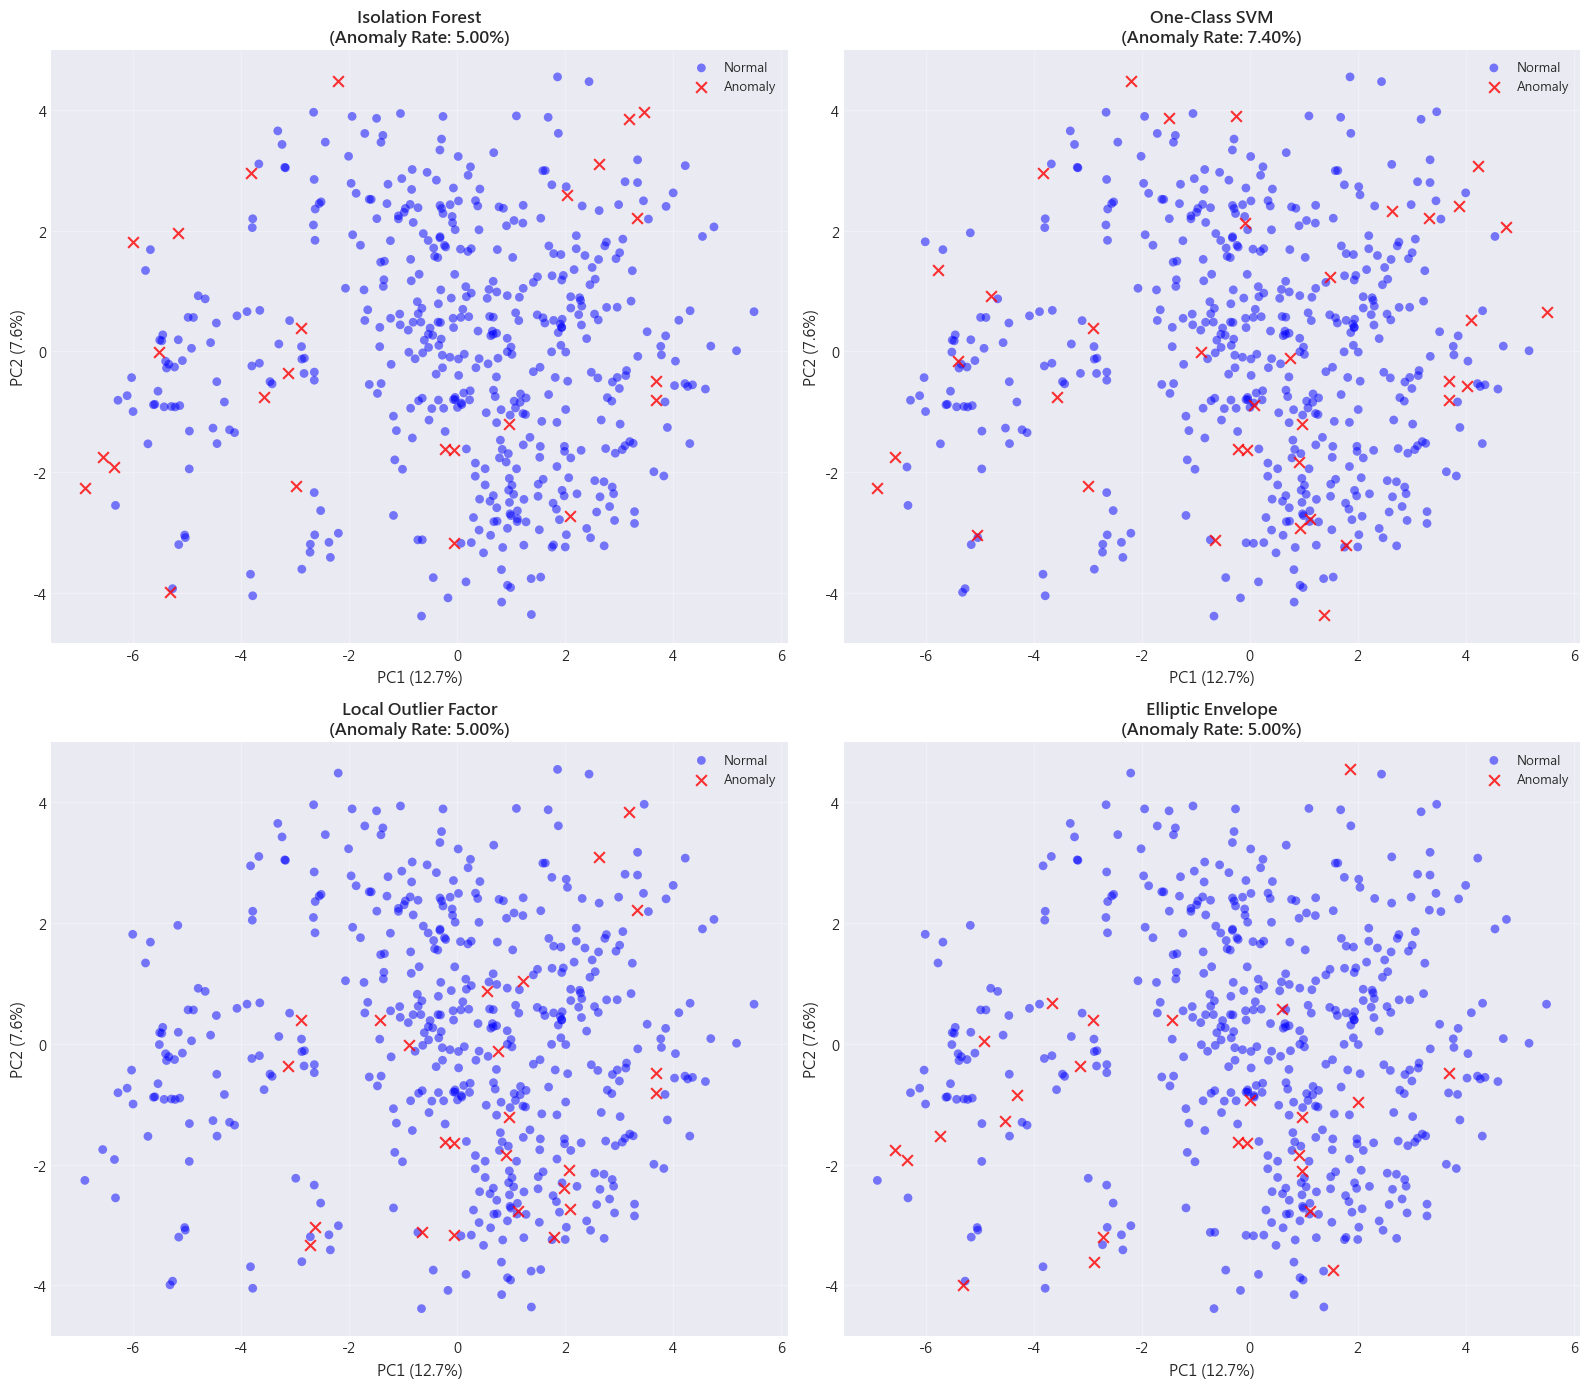


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\anomaly_detection_methods_comparison.png

異常點重疊分析

各方法檢測到的異常點數:
  - Isolation Forest: 25
  - One-Class SVM: 37
  - LOF: 25
  - Elliptic Envelope: 25

所有方法共識的異常點: 5 (高信心異常)


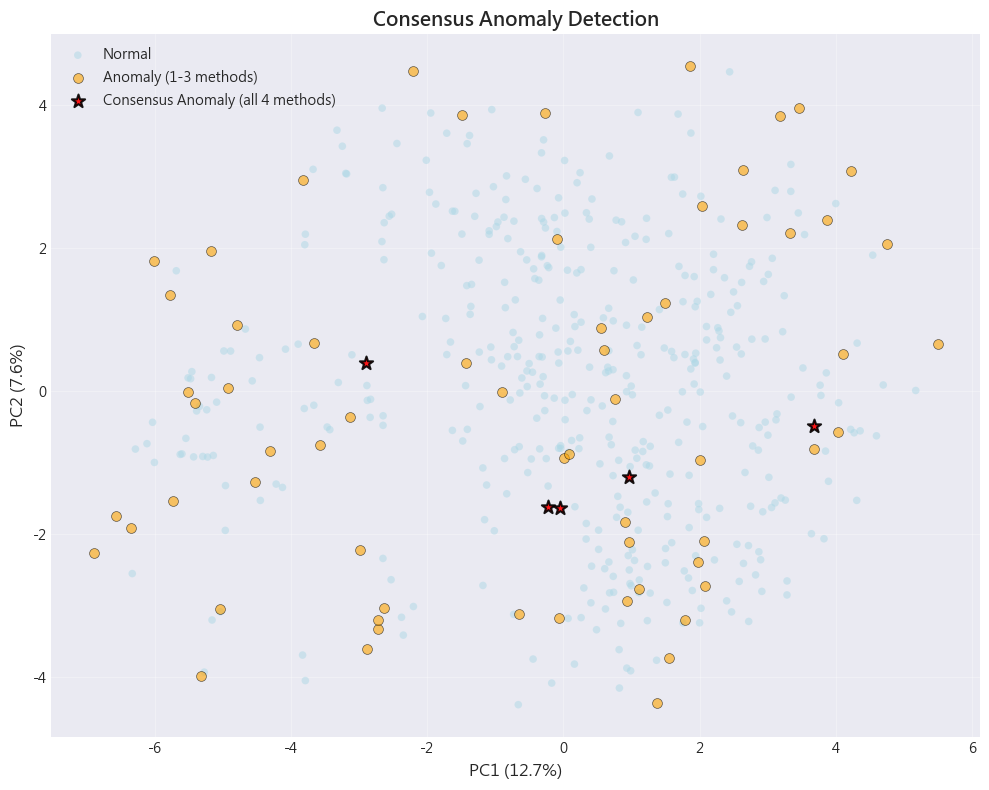


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\consensus_anomaly_detection.png


In [19]:
# ============================================================
# 4.3 其他異常檢測方法比較
# ============================================================

print("=" * 70)
print("多種異常檢測方法比較")
print("=" * 70)

contamination_rate = 0.05

# 1. Isolation Forest (已完成)
pred_iforest = train_pred
anomaly_rate_iforest = np.sum(pred_iforest == -1) / len(pred_iforest)
print(f"\n1. Isolation Forest")
print(f"   異常比例: {anomaly_rate_iforest:.2%}")

# 2. One-Class SVM
print("\n⏳ 正在訓練 One-Class SVM（預計耗時 1-3 分鐘）...")
print("💡 提示：One-Class SVM 計算較耗時，特別是大數據集")
start_time = time.time()

ocsvm = OneClassSVM(nu=contamination_rate, kernel='rbf', gamma='auto')
ocsvm.fit(X_train_scaled)
pred_ocsvm = ocsvm.predict(X_train_scaled)
anomaly_rate_ocsvm = np.sum(pred_ocsvm == -1) / len(pred_ocsvm)

elapsed_time = time.time() - start_time
print(f"✓ One-Class SVM 完成（耗時: {elapsed_time:.2f} 秒）")
print(f"2. One-Class SVM")
print(f"   異常比例: {anomaly_rate_ocsvm:.2%}")

# 3. Local Outlier Factor (LOF)
print("\n正在訓練 Local Outlier Factor...")
lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination_rate)
pred_lof = lof.fit_predict(X_train_scaled)
anomaly_rate_lof = np.sum(pred_lof == -1) / len(pred_lof)
print(f"3. Local Outlier Factor")
print(f"   異常比例: {anomaly_rate_lof:.2%}")

# 4. Elliptic Envelope (假設數據服從高斯分布)
print("\n正在訓練 Elliptic Envelope...")
elliptic = EllipticEnvelope(contamination=contamination_rate, random_state=42)
elliptic.fit(X_train_scaled)
pred_elliptic = elliptic.predict(X_train_scaled)
anomaly_rate_elliptic = np.sum(pred_elliptic == -1) / len(pred_elliptic)
print(f"4. Elliptic Envelope")
print(f"   異常比例: {anomaly_rate_elliptic:.2%}")

# 視覺化比較四種異常檢測方法 (在 PCA 空間中)
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

methods = [
    ('Isolation Forest', pred_iforest, anomaly_rate_iforest),
    ('One-Class SVM', pred_ocsvm, anomaly_rate_ocsvm),
    ('Local Outlier Factor', pred_lof, anomaly_rate_lof),
    ('Elliptic Envelope', pred_elliptic, anomaly_rate_elliptic)
]

for idx, (method_name, predictions, anom_rate) in enumerate(methods):
    # 繪製正常點
    normal_mask = predictions == 1
    axes[idx].scatter(X_train_pca[normal_mask, 0], X_train_pca[normal_mask, 1], 
                     c='blue', s=40, alpha=0.5, label='Normal', edgecolors='none')
    
    # 繪製異常點
    anomaly_mask = predictions == -1
    axes[idx].scatter(X_train_pca[anomaly_mask, 0], X_train_pca[anomaly_mask, 1], 
                     c='red', s=60, alpha=0.8, marker='x', linewidth=1.5, label='Anomaly')
    
    axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
    axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
    axes[idx].set_title(f'{method_name}\n(Anomaly Rate: {anom_rate:.2%})', 
                       fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9, loc='best')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'anomaly_detection_methods_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'anomaly_detection_methods_comparison.png'}")

# 異常點重疊分析
print("\n" + "=" * 70)
print("異常點重疊分析")
print("=" * 70)

# 計算各方法之間的異常點重疊
anomalies_iforest = set(np.where(pred_iforest == -1)[0])
anomalies_ocsvm = set(np.where(pred_ocsvm == -1)[0])
anomalies_lof = set(np.where(pred_lof == -1)[0])
anomalies_elliptic = set(np.where(pred_elliptic == -1)[0])

# 所有方法都認為是異常的點
consensus_anomalies = anomalies_iforest & anomalies_ocsvm & anomalies_lof & anomalies_elliptic

print(f"\n各方法檢測到的異常點數:")
print(f"  - Isolation Forest: {len(anomalies_iforest)}")
print(f"  - One-Class SVM: {len(anomalies_ocsvm)}")
print(f"  - LOF: {len(anomalies_lof)}")
print(f"  - Elliptic Envelope: {len(anomalies_elliptic)}")
print(f"\n所有方法共識的異常點: {len(consensus_anomalies)} (高信心異常)")

# 視覺化共識異常點
fig, ax = plt.subplots(figsize=(10, 8))

# 繪製所有正常點
all_normal = np.ones(len(X_train_pca), dtype=bool)
for pred in [pred_iforest, pred_ocsvm, pred_lof, pred_elliptic]:
    all_normal &= (pred == 1)

ax.scatter(X_train_pca[all_normal, 0], X_train_pca[all_normal, 1], 
          c='lightblue', s=30, alpha=0.5, label='Normal', edgecolors='none')

# 繪製至少一種方法檢測到的異常點
at_least_one = np.zeros(len(X_train_pca), dtype=bool)
for pred in [pred_iforest, pred_ocsvm, pred_lof, pred_elliptic]:
    at_least_one |= (pred == -1)
at_least_one &= ~np.array([i in consensus_anomalies for i in range(len(X_train_pca))])

ax.scatter(X_train_pca[at_least_one, 0], X_train_pca[at_least_one, 1], 
          c='orange', s=50, alpha=0.6, marker='o', label='Anomaly (1-3 methods)', edgecolors='k', linewidth=0.5)

# 繪製共識異常點
consensus_mask = np.array([i in consensus_anomalies for i in range(len(X_train_pca))])
ax.scatter(X_train_pca[consensus_mask, 0], X_train_pca[consensus_mask, 1], 
          c='red', s=100, alpha=0.9, marker='*', label='Consensus Anomaly (all 4 methods)', 
          edgecolors='black', linewidth=1.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.set_title('Consensus Anomaly Detection', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'consensus_anomaly_detection.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'consensus_anomaly_detection.png'}")

異常檢測決策邊界比較


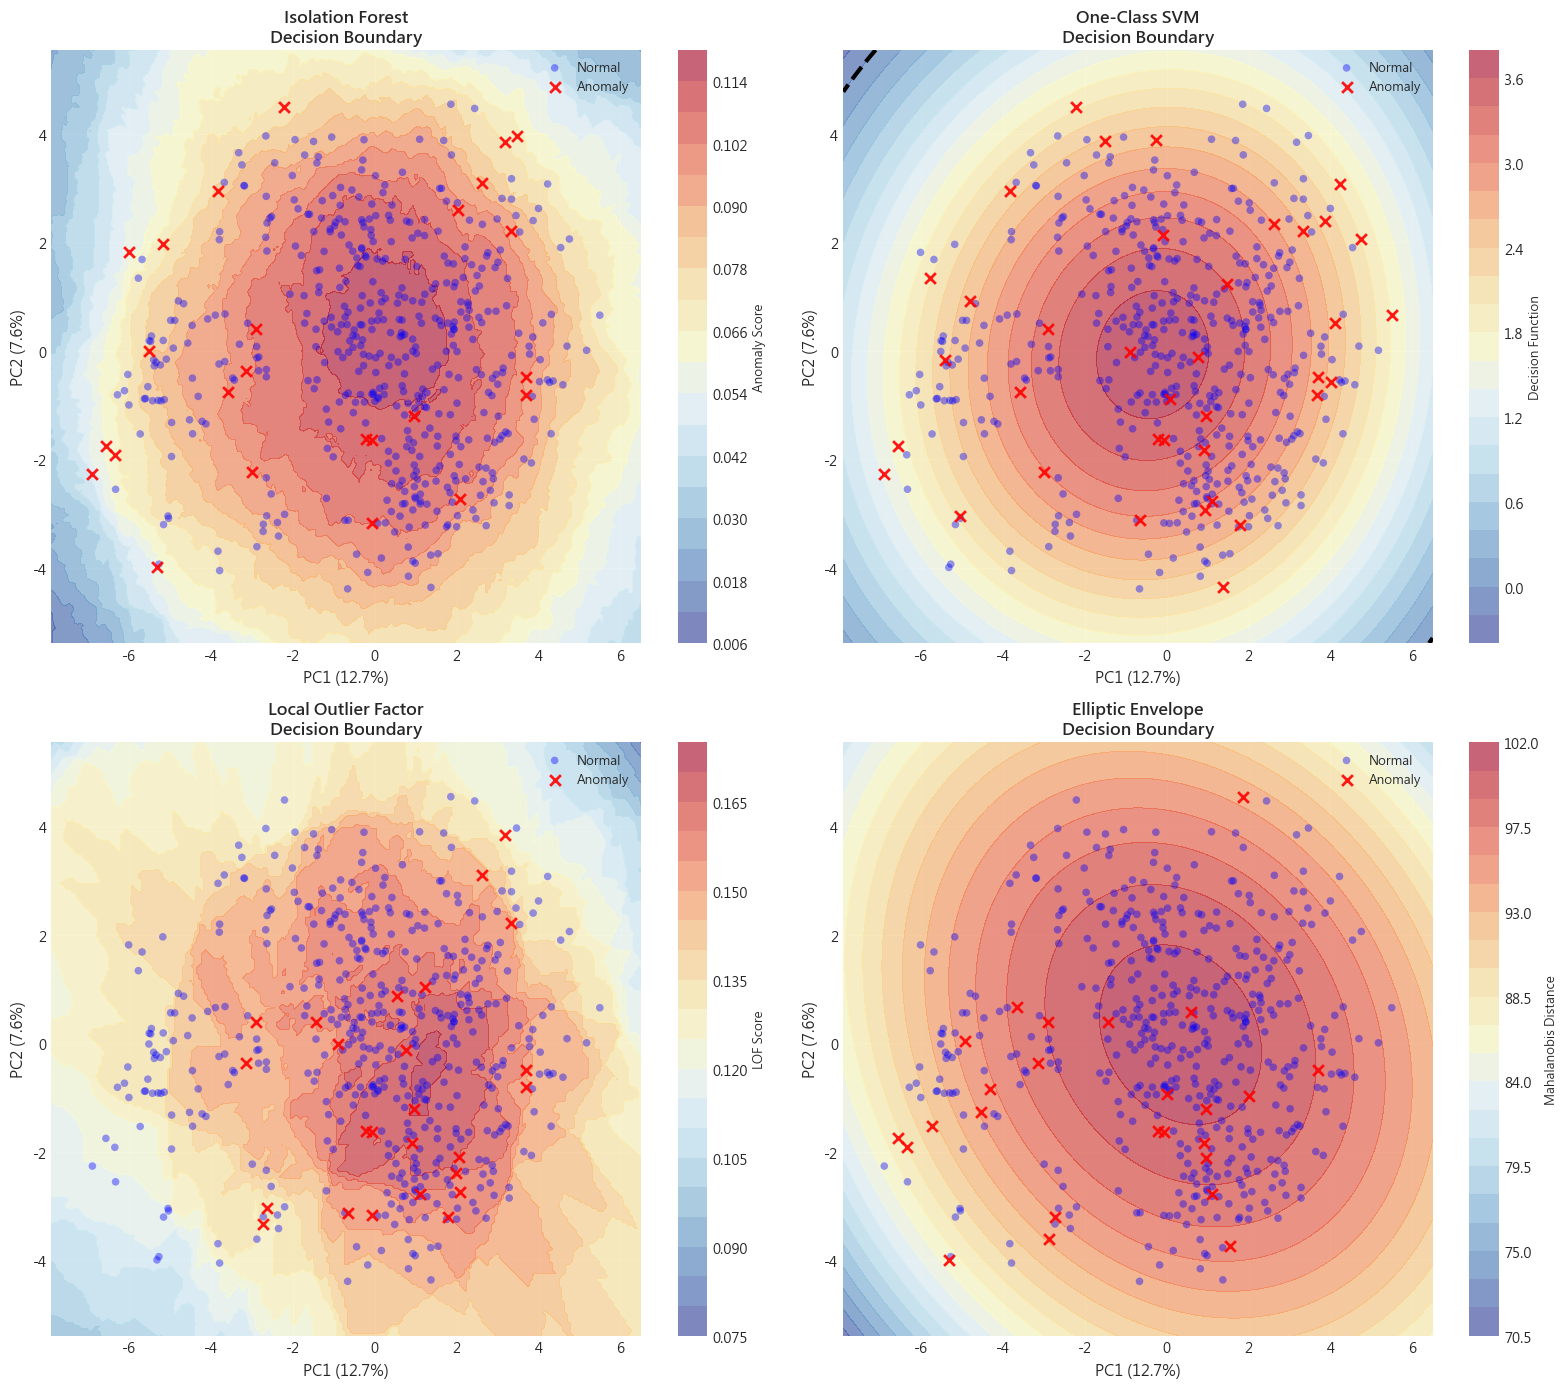


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\anomaly_decision_boundaries.png

💡 決策邊界解讀:
  • 藍色區域：模型認為「正常」的區域
  • 紅色區域：模型認為「異常」的區域
  • 黑色虛線：決策邊界（異常分數 = 0）

📌 方法差異:
  • Isolation Forest: 邊界較複雜，能捕捉局部異常
  • One-Class SVM: 邊界較平滑，傾向於找出整體輪廓
  • LOF: 基於密度，邊界會隨局部密度變化
  • Elliptic Envelope: 假設高斯分布，邊界呈橢圓形


In [20]:
# ============================================================
# 異常檢測決策邊界視覺化
# ============================================================

print("=" * 70)
print("異常檢測決策邊界比較")
print("=" * 70)

# 創建網格用於繪製決策邊界
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# 將網格點轉換回原始特徵空間進行預測
grid_pca = np.c_[xx.ravel(), yy.ravel()]
# 需要先逆轉換到標準化空間（僅使用前2個PC）
grid_pca_full = np.zeros((grid_pca.shape[0], X_train_pca.shape[1]))
grid_pca_full[:, :2] = grid_pca
grid_scaled = pca.inverse_transform(grid_pca_full)

# 使用各方法預測網格點
Z_iforest = iso_forest.decision_function(grid_scaled).reshape(xx.shape)
Z_ocsvm = ocsvm.decision_function(grid_scaled).reshape(xx.shape)
Z_elliptic = elliptic.decision_function(grid_scaled).reshape(xx.shape)

# LOF 需要特殊處理（使用訓練時的 novelty=True 版本）
lof_boundary = LocalOutlierFactor(n_neighbors=20, contamination=contamination_rate, novelty=True)
lof_boundary.fit(X_train_scaled)
Z_lof = lof_boundary.decision_function(grid_scaled).reshape(xx.shape)

# 視覺化
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

methods_boundary = [
    ('Isolation Forest', Z_iforest, pred_iforest, 'Anomaly Score'),
    ('One-Class SVM', Z_ocsvm, pred_ocsvm, 'Decision Function'),
    ('Local Outlier Factor', Z_lof, pred_lof, 'LOF Score'),
    ('Elliptic Envelope', Z_elliptic, pred_elliptic, 'Mahalanobis Distance')
]

for idx, (name, Z, predictions, score_name) in enumerate(methods_boundary):
    # 繪製決策邊界（等高線）
    contour = axes[idx].contourf(xx, yy, Z, levels=20, cmap='RdYlBu_r', alpha=0.6)
    
    # 繪製決策邊界線 (異常分數 = 0)
    axes[idx].contour(xx, yy, Z, levels=[0], linewidths=3, colors='black', linestyles='--')
    
    # 繪製訓練數據點
    normal_mask = predictions == 1
    anomaly_mask = predictions == -1
    
    axes[idx].scatter(X_train_pca[normal_mask, 0], X_train_pca[normal_mask, 1],
                     c='blue', s=30, alpha=0.4, edgecolors='none', label='Normal')
    axes[idx].scatter(X_train_pca[anomaly_mask, 0], X_train_pca[anomaly_mask, 1],
                     c='red', s=60, alpha=0.9, marker='x', linewidth=2, label='Anomaly')
    
    axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
    axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
    axes[idx].set_title(f'{name}\nDecision Boundary', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9, loc='best')
    axes[idx].grid(True, alpha=0.3)
    
    # 添加顏色條
    cbar = plt.colorbar(contour, ax=axes[idx])
    cbar.set_label(score_name, fontsize=9)

plt.tight_layout()
plt.savefig(FIG_DIR / 'anomaly_decision_boundaries.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'anomaly_decision_boundaries.png'}")
print("\n💡 決策邊界解讀:")
print("  • 藍色區域：模型認為「正常」的區域")
print("  • 紅色區域：模型認為「異常」的區域")
print("  • 黑色虛線：決策邊界（異常分數 = 0）")
print("\n📌 方法差異:")
print("  • Isolation Forest: 邊界較複雜，能捕捉局部異常")
print("  • One-Class SVM: 邊界較平滑，傾向於找出整體輪廓")
print("  • LOF: 基於密度，邊界會隨局部密度變化")
print("  • Elliptic Envelope: 假設高斯分布，邊界呈橢圓形")

#### 📊 深入理解：異常檢測方法的決策邊界比較

讓我們通過**決策邊界視覺化**來理解不同異常檢測方法如何定義「正常」與「異常」的邊界。

### 4.4 故障場景分析：載入故障數據進行故障檢測

TEP 數據集包含 21 種預定義故障場景。我們將載入 IDV 1 故障數據，並比較正常操作與故障操作在各種分析方法下的差異。

故障場景分析：IDV 1 (A/C Feed Ratio, B Composition Constant)
正在載入: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\data\TEP_data\d01.dat
原始數據形狀: (480, 52)
  → 檢測到標準格式
最終數據形狀: (480, 52) (samples × features)
時間範圍: 0 - 1437 minutes

正在載入: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\data\TEP_data\d01_te.dat
原始數據形狀: (960, 52)
  → 檢測到標準格式
最終數據形狀: (960, 52) (samples × features)
時間範圍: 0 - 2877 minutes


✓ 故障數據載入完成
故障訓練數據形狀: (480, 52)
故障測試數據形狀: (960, 52)

異常檢測結果:
  正常操作 (訓練): 5.00% 異常
  正常操作 (測試): 20.00% 異常
  故障操作 (訓練): 98.75% 異常
  故障操作 (測試): 83.33% 異常


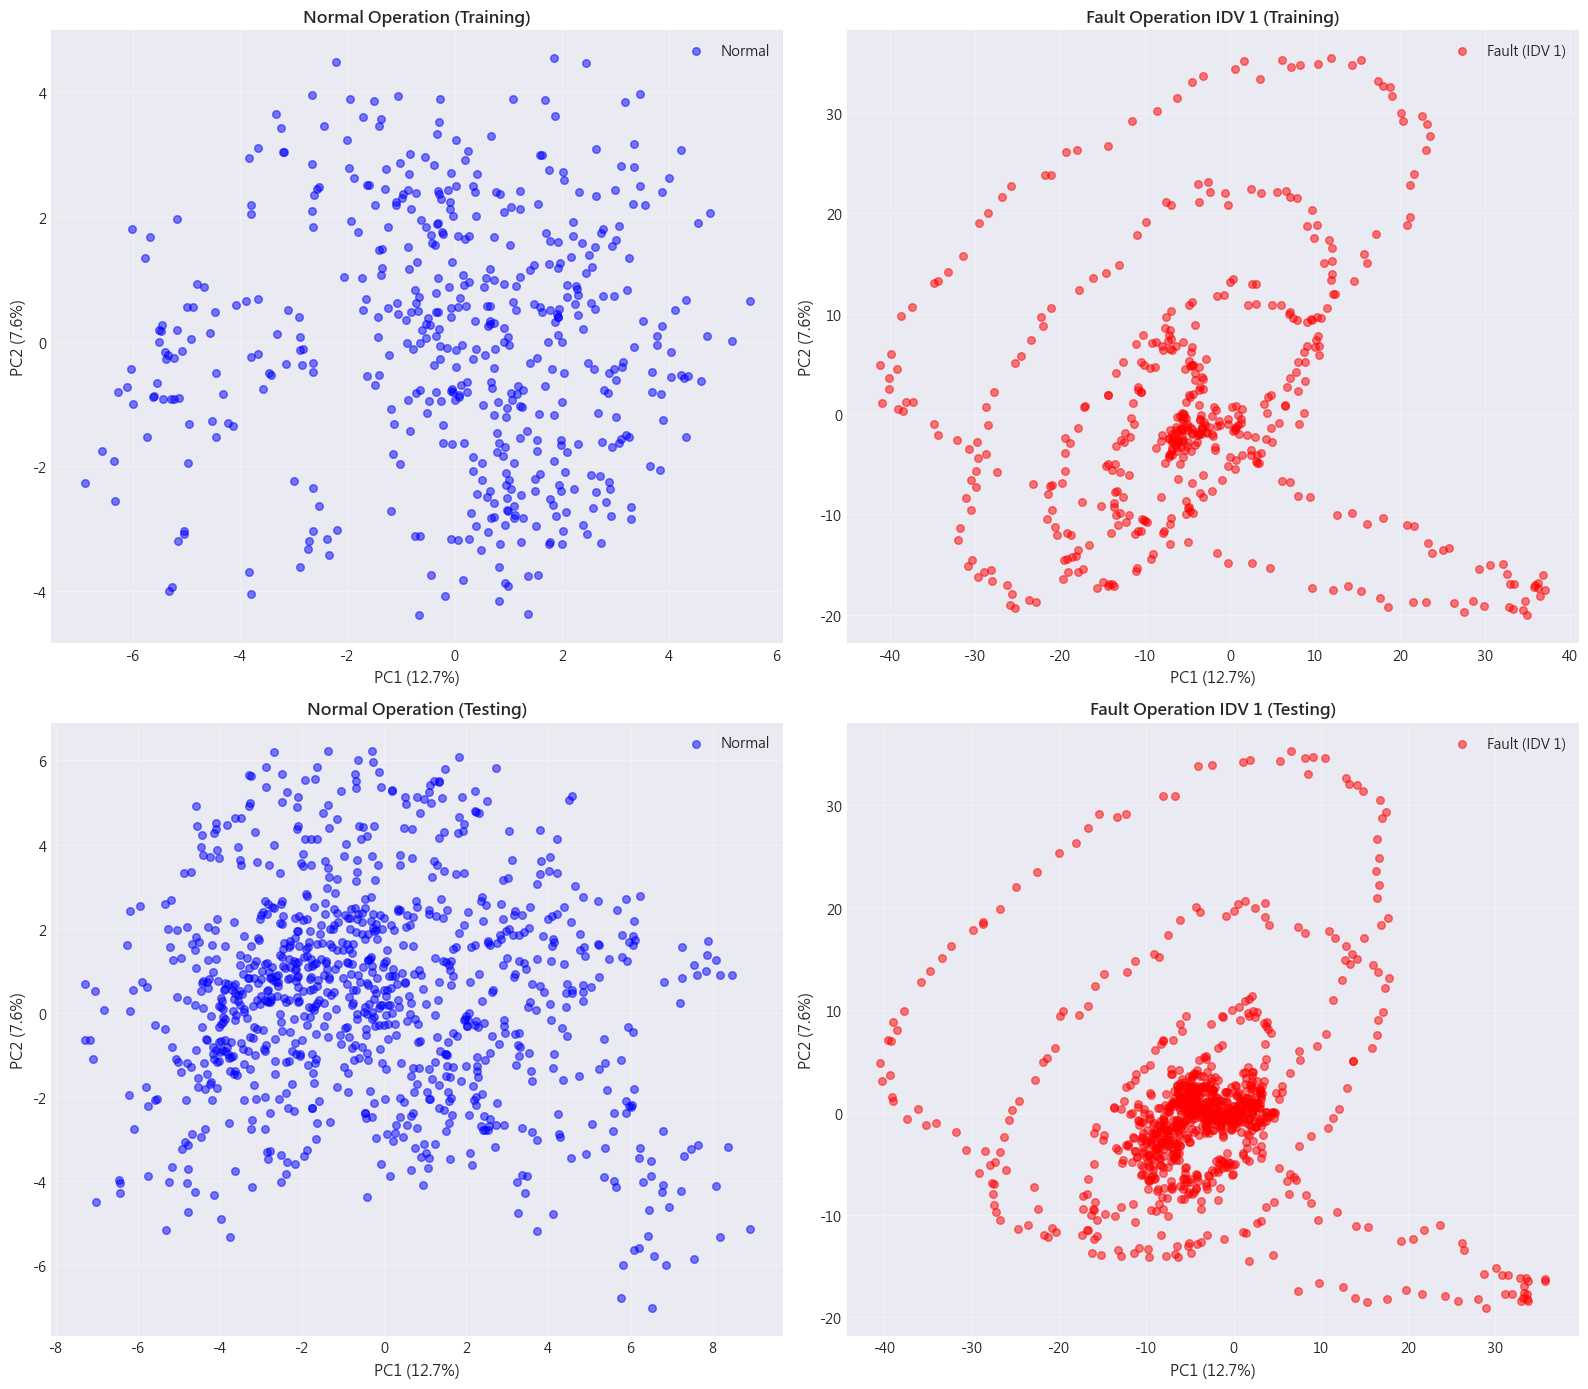


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\normal_vs_fault_comparison.png


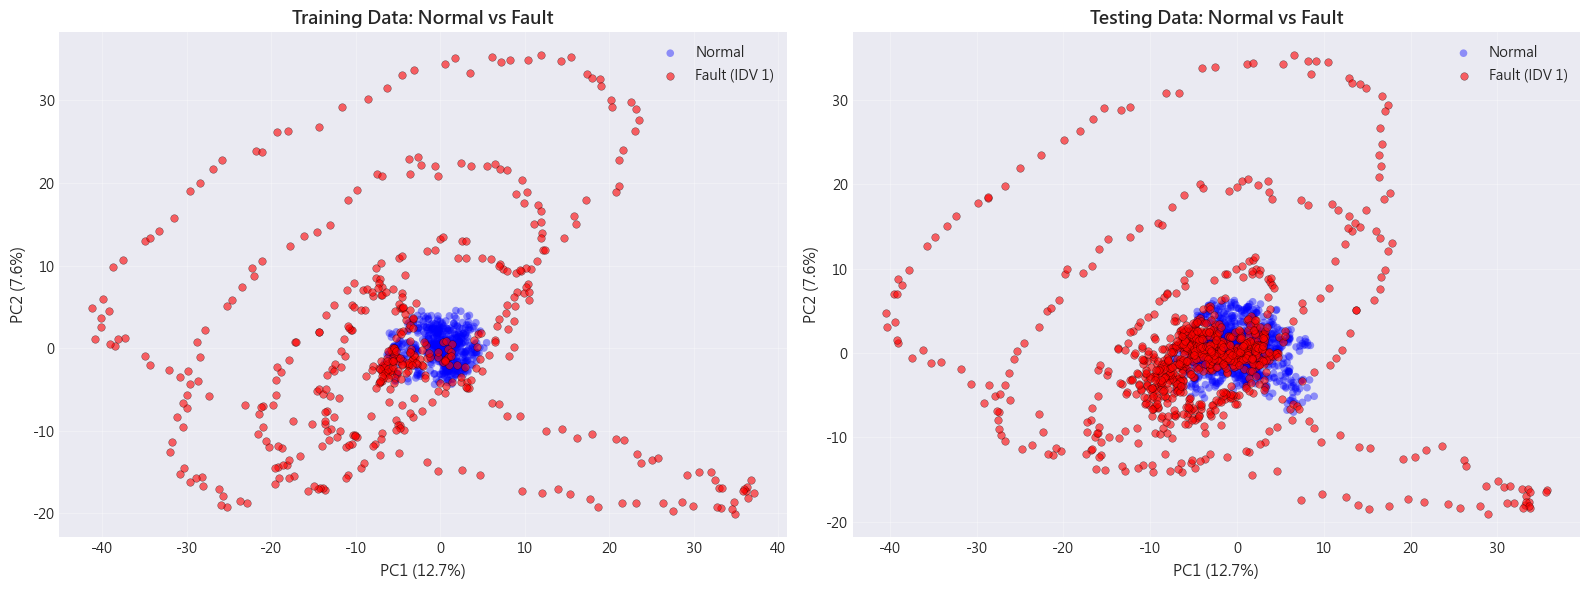

✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\combined_normal_vs_fault.png


In [21]:
# ============================================================
# 4.4 故障場景分析：載入並分析故障數據
# ============================================================

print("=" * 70)
print("故障場景分析：IDV 1 (A/C Feed Ratio, B Composition Constant)")
print("=" * 70)

# 載入故障數據 (IDV 1)
df_fault_train = load_tep_data(DATA_DIR, fault_id=1, data_type='train')
df_fault_test = load_tep_data(DATA_DIR, fault_id=1, data_type='test')

# 標準化故障數據 (使用正常數據的 scaler)
X_fault_train = df_fault_train[feature_cols].values
X_fault_train_scaled = scaler.transform(X_fault_train)

X_fault_test = df_fault_test[feature_cols].values
X_fault_test_scaled = scaler.transform(X_fault_test)

print("\n✓ 故障數據載入完成")
print(f"故障訓練數據形狀: {X_fault_train_scaled.shape}")
print(f"故障測試數據形狀: {X_fault_test_scaled.shape}")

# PCA 投影故障數據
X_fault_train_pca = pca.transform(X_fault_train_scaled)
X_fault_test_pca = pca.transform(X_fault_test_scaled)

# 使用訓練好的異常檢測模型預測故障數據
fault_pred_train = iso_forest.predict(X_fault_train_scaled)
fault_pred_test = iso_forest.predict(X_fault_test_scaled)

fault_anomaly_rate_train = np.sum(fault_pred_train == -1) / len(fault_pred_train)
fault_anomaly_rate_test = np.sum(fault_pred_test == -1) / len(fault_pred_test)

print("\n異常檢測結果:")
print(f"  正常操作 (訓練): {np.sum(train_pred == -1) / len(train_pred):.2%} 異常")
print(f"  正常操作 (測試): {np.sum(test_pred == -1) / len(test_pred):.2%} 異常")
print(f"  故障操作 (訓練): {fault_anomaly_rate_train:.2%} 異常")
print(f"  故障操作 (測試): {fault_anomaly_rate_test:.2%} 異常")

# 視覺化正常與故障數據的對比
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 左上: 正常訓練數據在 PCA 空間
axes[0, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                  c='blue', s=30, alpha=0.5, label='Normal')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0, 0].set_title('Normal Operation (Training)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 右上: 故障訓練數據在 PCA 空間
axes[0, 1].scatter(X_fault_train_pca[:, 0], X_fault_train_pca[:, 1], 
                  c='red', s=30, alpha=0.5, label='Fault (IDV 1)')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0, 1].set_title('Fault Operation IDV 1 (Training)', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 左下: 正常測試數據在 PCA 空間
axes[1, 0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                  c='blue', s=30, alpha=0.5, label='Normal')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1, 0].set_title('Normal Operation (Testing)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 右下: 故障測試數據在 PCA 空間
axes[1, 1].scatter(X_fault_test_pca[:, 0], X_fault_test_pca[:, 1], 
                  c='red', s=30, alpha=0.5, label='Fault (IDV 1)')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1, 1].set_title('Fault Operation IDV 1 (Testing)', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'normal_vs_fault_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'normal_vs_fault_comparison.png'}")

# 組合視覺化：正常與故障數據在同一圖中
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 訓練數據
axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
               c='blue', s=30, alpha=0.4, label='Normal', edgecolors='none')
axes[0].scatter(X_fault_train_pca[:, 0], X_fault_train_pca[:, 1], 
               c='red', s=30, alpha=0.6, label='Fault (IDV 1)', edgecolors='k', linewidth=0.3)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title('Training Data: Normal vs Fault', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 測試數據
axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
               c='blue', s=30, alpha=0.4, label='Normal', edgecolors='none')
axes[1].scatter(X_fault_test_pca[:, 0], X_fault_test_pca[:, 1], 
               c='red', s=30, alpha=0.6, label='Fault (IDV 1)', edgecolors='k', linewidth=0.3)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1].set_title('Testing Data: Normal vs Fault', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'combined_normal_vs_fault.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 圖表已儲存至: {FIG_DIR / 'combined_normal_vs_fault.png'}")

### 4.5 故障診斷效能評估

使用正常數據訓練的模型來檢測故障數據，評估模型的故障診斷能力。

故障診斷效能評估

故障診斷性能指標:
----------------------------------------------------------------------
Method               Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------
Isolation Forest     0.817        0.806        0.833        0.820       
One-Class SVM        0.717        0.667        0.867        0.754       
LOF                  0.812        0.787        0.855        0.820       
Elliptic Envelope    0.851        0.857        0.843        0.850       


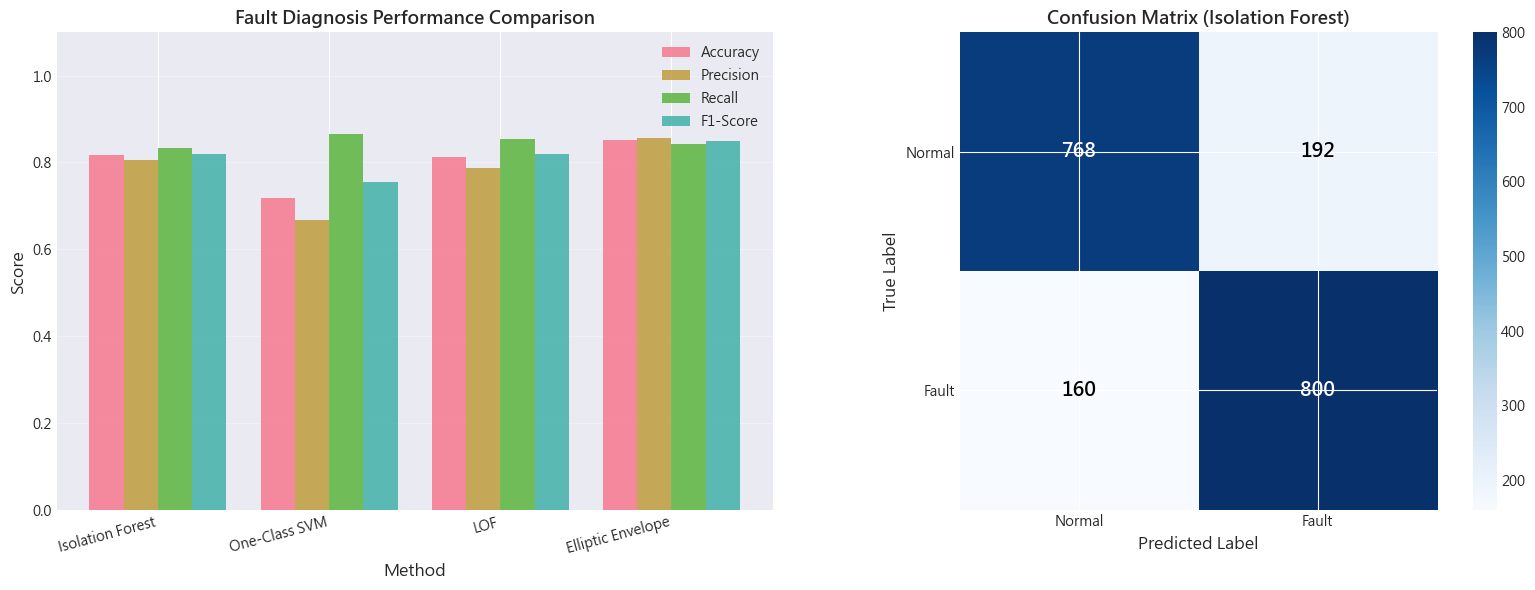


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\fault_diagnosis_performance.png

詳細分類報告 (Isolation Forest)
              precision    recall  f1-score   support

      Normal      0.828     0.800     0.814       960
       Fault      0.806     0.833     0.820       960

    accuracy                          0.817      1920
   macro avg      0.817     0.817     0.817      1920
weighted avg      0.817     0.817     0.817      1920



In [22]:
# ============================================================
# 4.5 故障診斷效能評估
# ============================================================

print("=" * 70)
print("故障診斷效能評估")
print("=" * 70)

# 創建標籤：正常=0, 故障=1
# 測試數據標籤
y_test_true = np.concatenate([
    np.zeros(len(X_test_scaled)),      # 正常數據
    np.ones(len(X_fault_test_scaled))  # 故障數據
])

# 組合測試數據
X_test_combined = np.vstack([X_test_scaled, X_fault_test_scaled])

# 使用各種異常檢測方法預測組合測試數據
# 預測值轉換: -1 (異常) -> 1 (故障), 1 (正常) -> 0 (正常)
pred_combined_iforest = iso_forest.predict(X_test_combined)
y_pred_iforest = (pred_combined_iforest == -1).astype(int)

pred_combined_ocsvm = ocsvm.predict(X_test_combined)
y_pred_ocsvm = (pred_combined_ocsvm == -1).astype(int)

# LOF 需要重新訓練 (因為 fit_predict 不能用於新數據)
lof_test = LocalOutlierFactor(n_neighbors=20, contamination=contamination_rate, novelty=True)
lof_test.fit(X_train_scaled)
pred_combined_lof = lof_test.predict(X_test_combined)
y_pred_lof = (pred_combined_lof == -1).astype(int)

pred_combined_elliptic = elliptic.predict(X_test_combined)
y_pred_elliptic = (pred_combined_elliptic == -1).astype(int)

# 計算性能指標
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

methods_predictions = {
    'Isolation Forest': y_pred_iforest,
    'One-Class SVM': y_pred_ocsvm,
    'LOF': y_pred_lof,
    'Elliptic Envelope': y_pred_elliptic
}

print("\n故障診斷性能指標:")
print("-" * 70)
print(f"{'Method':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)

performance_results = []
for method_name, y_pred in methods_predictions.items():
    acc = accuracy_score(y_test_true, y_pred)
    prec = precision_score(y_test_true, y_pred, zero_division=0)
    rec = recall_score(y_test_true, y_pred, zero_division=0)
    f1 = f1_score(y_test_true, y_pred, zero_division=0)
    
    print(f"{method_name:<20} {acc:<12.3f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f}")
    performance_results.append({
        'Method': method_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

# 視覺化性能比較
df_performance = pd.DataFrame(performance_results)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：各指標比較
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(methods_predictions))
width = 0.2

for i, metric in enumerate(metrics):
    axes[0].bar(x_pos + i * width, df_performance[metric], width, 
               label=metric, alpha=0.8)

axes[0].set_xlabel('Method', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Fault Diagnosis Performance Comparison', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos + width * 1.5)
axes[0].set_xticklabels(df_performance['Method'], rotation=15, ha='right')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])

# 右圖：Confusion Matrix for Isolation Forest
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_iforest)

im = axes[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].figure.colorbar(im, ax=axes[1])

# 添加文本標註
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[1].text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=14, fontweight='bold')

axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title('Confusion Matrix (Isolation Forest)', fontsize=13, fontweight='bold')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Normal', 'Fault'])
axes[1].set_yticklabels(['Normal', 'Fault'])

plt.tight_layout()
plt.savefig(FIG_DIR / 'fault_diagnosis_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'fault_diagnosis_performance.png'}")

# 詳細分類報告 (Isolation Forest)
print("\n" + "=" * 70)
print("詳細分類報告 (Isolation Forest)")
print("=" * 70)
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_iforest, 
                           target_names=['Normal', 'Fault'], 
                           digits=3))

異常檢測方法綜合性能比較（雷達圖）


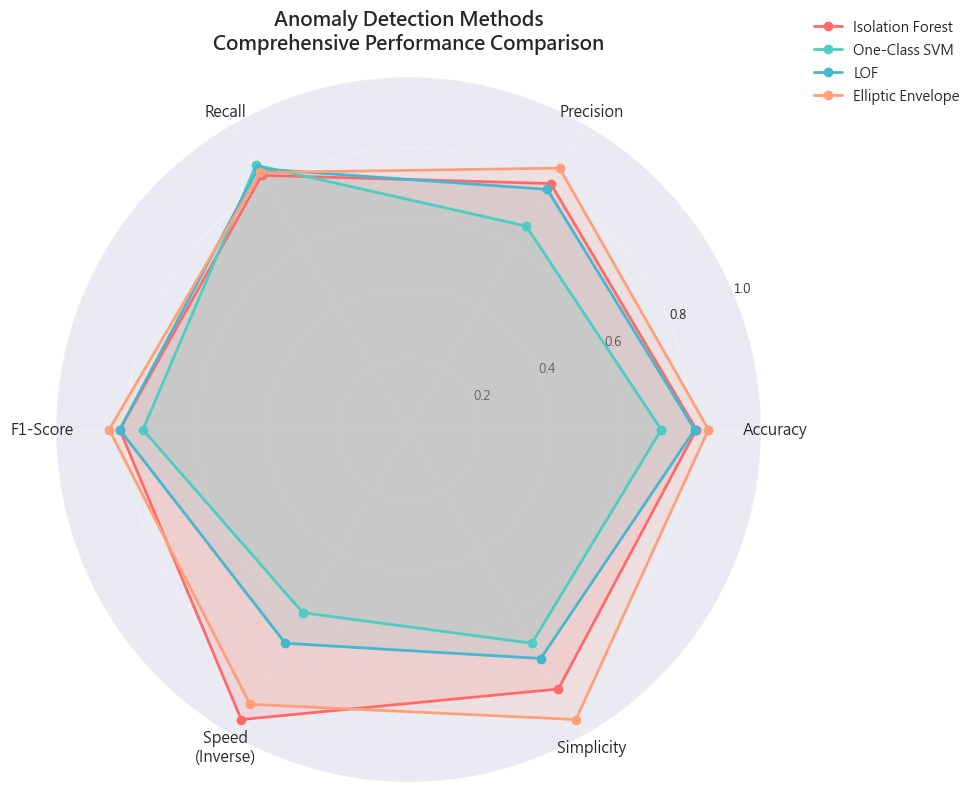


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\methods_radar_comparison.png

💡 雷達圖解讀:
  • 面積越大：整體性能越好
  • 形狀：反映方法的特性（平衡型 vs 特化型）

📌 方法特性總結:
  • Isolation Forest: 速度快、實現簡單，性能均衡
  • One-Class SVM: Recall 高但 Precision 低，計算較慢
  • LOF: 性能均衡，適合檢測局部異常
  • Elliptic Envelope: 整體性能最佳，速度快，假設高斯分布


In [23]:
# ============================================================
# 方法綜合比較：性能雷達圖
# ============================================================

print("=" * 70)
print("異常檢測方法綜合性能比較（雷達圖）")
print("=" * 70)

# 定義評估維度（0-1 標準化）
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Speed\n(Inverse)', 'Simplicity']

# 各方法的性能數據（基於實際結果，Speed 和 Simplicity 為經驗估計）
# Speed: 1-訓練時間排名歸一化, Simplicity: 1-複雜度排名歸一化
performance_data = {
    'Isolation Forest': [
        df_performance[df_performance['Method'] == 'Isolation Forest']['Accuracy'].values[0],
        df_performance[df_performance['Method'] == 'Isolation Forest']['Precision'].values[0],
        df_performance[df_performance['Method'] == 'Isolation Forest']['Recall'].values[0],
        df_performance[df_performance['Method'] == 'Isolation Forest']['F1-Score'].values[0],
        0.95,  # Speed (很快)
        0.85   # Simplicity (較簡單)
    ],
    'One-Class SVM': [
        df_performance[df_performance['Method'] == 'One-Class SVM']['Accuracy'].values[0],
        df_performance[df_performance['Method'] == 'One-Class SVM']['Precision'].values[0],
        df_performance[df_performance['Method'] == 'One-Class SVM']['Recall'].values[0],
        df_performance[df_performance['Method'] == 'One-Class SVM']['F1-Score'].values[0],
        0.60,  # Speed (較慢)
        0.70   # Simplicity (中等)
    ],
    'LOF': [
        df_performance[df_performance['Method'] == 'LOF']['Accuracy'].values[0],
        df_performance[df_performance['Method'] == 'LOF']['Precision'].values[0],
        df_performance[df_performance['Method'] == 'LOF']['Recall'].values[0],
        df_performance[df_performance['Method'] == 'LOF']['F1-Score'].values[0],
        0.70,  # Speed (中等)
        0.75   # Simplicity (較簡單)
    ],
    'Elliptic Envelope': [
        df_performance[df_performance['Method'] == 'Elliptic Envelope']['Accuracy'].values[0],
        df_performance[df_performance['Method'] == 'Elliptic Envelope']['Precision'].values[0],
        df_performance[df_performance['Method'] == 'Elliptic Envelope']['Recall'].values[0],
        df_performance[df_performance['Method'] == 'Elliptic Envelope']['F1-Score'].values[0],
        0.90,  # Speed (快)
        0.95   # Simplicity (最簡單)
    ]
}

# 繪製雷達圖
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # 閉合圖形

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
for idx, (method, values) in enumerate(performance_data.items()):
    values += values[:1]  # 閉合圖形
    ax.plot(angles, values, 'o-', linewidth=2, label=method, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
ax.set_title('Anomaly Detection Methods\nComprehensive Performance Comparison', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'methods_radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'methods_radar_comparison.png'}")
print("\n💡 雷達圖解讀:")
print("  • 面積越大：整體性能越好")
print("  • 形狀：反映方法的特性（平衡型 vs 特化型）")
print("\n📌 方法特性總結:")
print("  • Isolation Forest: 速度快、實現簡單，性能均衡")
print("  • One-Class SVM: Recall 高但 Precision 低，計算較慢")
print("  • LOF: 性能均衡，適合檢測局部異常")
print("  • Elliptic Envelope: 整體性能最佳，速度快，假設高斯分布")

非監督學習方法選擇決策流程圖


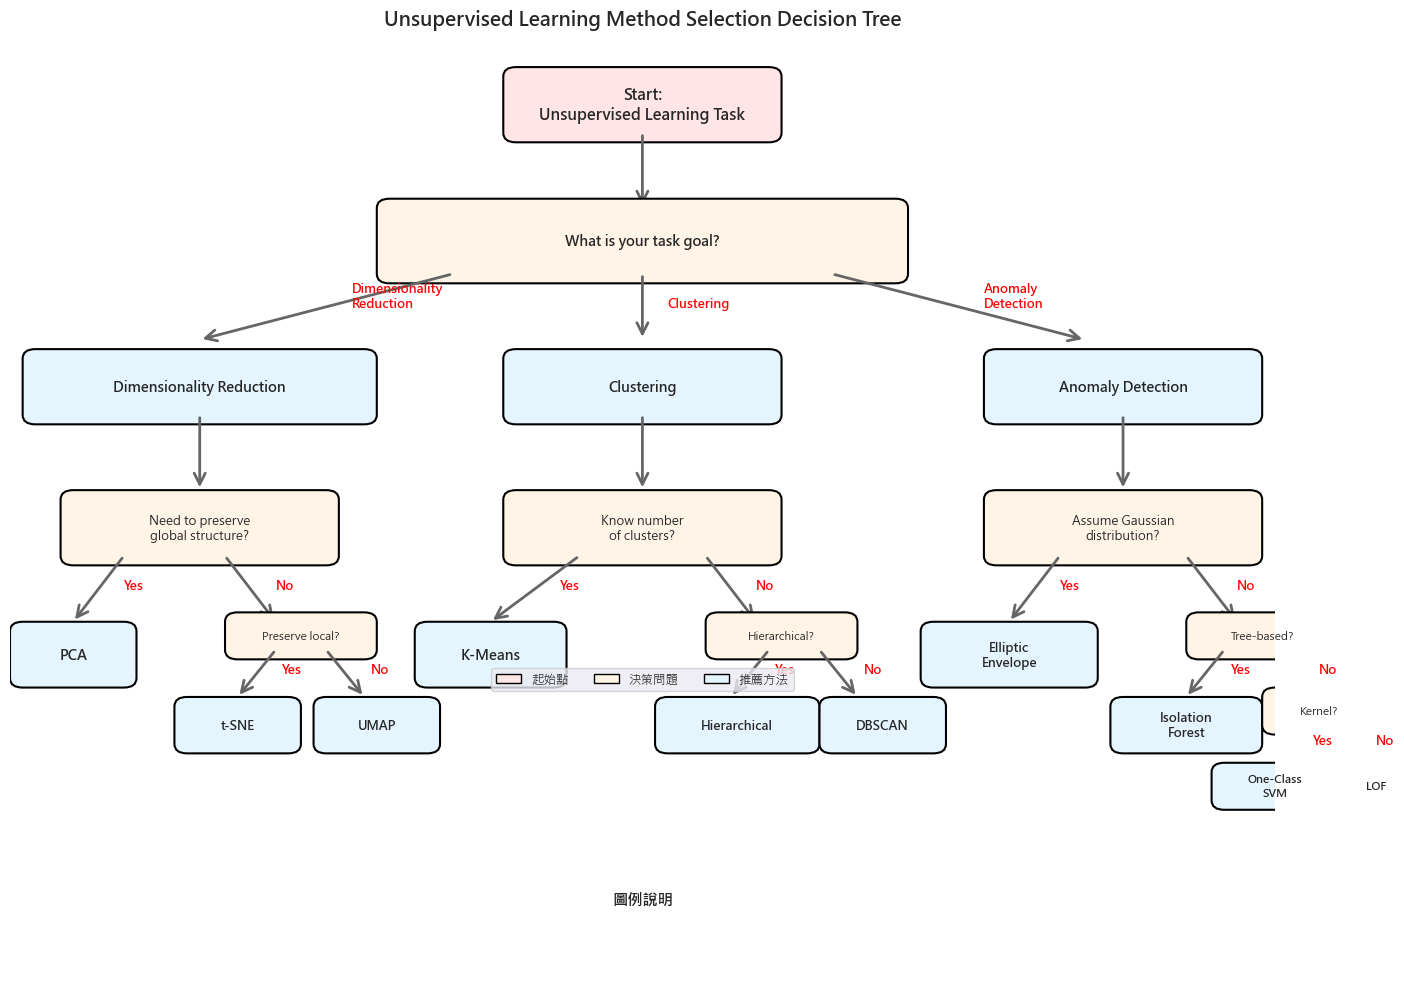


✓ 決策流程圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\method_selection_flowchart.png

💡 使用建議:
  1. 首先確定任務目標（降維/聚類/異常檢測）
  2. 根據數據特性和需求回答決策問題
  3. 遵循流程圖路徑找到推薦方法
  4. 可嘗試多種方法並比較結果


In [24]:
# ============================================================
# 非監督學習方法選擇決策流程圖
# ============================================================

print("=" * 70)
print("非監督學習方法選擇決策流程圖")
print("=" * 70)

import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# 定義顏色
color_start = '#FFE5E5'
color_question = '#FFF4E5'
color_result = '#E5F5FF'
color_arrow = '#666666'

# 輔助函數：繪製方框
def draw_box(ax, x, y, width, height, text, color, fontsize=10, fontweight='normal'):
    box = FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.1",
                          edgecolor='black', facecolor=color, linewidth=1.5)
    ax.add_patch(box)
    ax.text(x + width/2, y + height/2, text, ha='center', va='center',
            fontsize=fontsize, fontweight=fontweight, wrap=True)

# 輔助函數：繪製箭頭
def draw_arrow(ax, x1, y1, x2, y2, label=''):
    arrow = FancyArrowPatch((x1, y1), (x2, y2),
                            arrowstyle='->', mutation_scale=20,
                            color=color_arrow, linewidth=2)
    ax.add_patch(arrow)
    if label:
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        ax.text(mid_x + 0.2, mid_y, label, fontsize=9, color='red', fontweight='bold')

# 繪製決策流程

# 起點
draw_box(ax, 4, 9, 2, 0.6, 'Start:\nUnsupervised Learning Task', color_start, fontsize=11, fontweight='bold')

# 第一層決策：任務類型
draw_arrow(ax, 5, 9, 5, 8.2)
draw_box(ax, 3, 7.5, 4, 0.7, 'What is your task goal?', color_question, fontsize=10, fontweight='bold')

# 三個分支
draw_arrow(ax, 3.5, 7.5, 1.5, 6.8, 'Dimensionality\nReduction')
draw_arrow(ax, 5, 7.5, 5, 6.8, 'Clustering')
draw_arrow(ax, 6.5, 7.5, 8.5, 6.8, 'Anomaly\nDetection')

# === 降維分支 ===
draw_box(ax, 0.2, 6, 2.6, 0.6, 'Dimensionality Reduction', color_result, fontsize=10, fontweight='bold')
draw_arrow(ax, 1.5, 6, 1.5, 5.2)
draw_box(ax, 0.5, 4.5, 2, 0.6, 'Need to preserve\nglobal structure?', color_question, fontsize=9)
draw_arrow(ax, 0.9, 4.5, 0.5, 3.8, 'Yes')
draw_box(ax, 0.1, 3.2, 0.8, 0.5, 'PCA', color_result, fontsize=10, fontweight='bold')
draw_arrow(ax, 1.7, 4.5, 2.1, 3.8, 'No')
draw_box(ax, 1.8, 3.5, 1, 0.3, 'Preserve local?', color_question, fontsize=8)
draw_arrow(ax, 2.1, 3.5, 1.8, 3.0, 'Yes')
draw_box(ax, 1.4, 2.5, 0.8, 0.4, 't-SNE', color_result, fontsize=9, fontweight='bold')
draw_arrow(ax, 2.5, 3.5, 2.8, 3.0, 'No')
draw_box(ax, 2.5, 2.5, 0.8, 0.4, 'UMAP', color_result, fontsize=9, fontweight='bold')

# === 聚類分支 ===
draw_box(ax, 4, 6, 2, 0.6, 'Clustering', color_result, fontsize=10, fontweight='bold')
draw_arrow(ax, 5, 6, 5, 5.2)
draw_box(ax, 4, 4.5, 2, 0.6, 'Know number\nof clusters?', color_question, fontsize=9)
draw_arrow(ax, 4.5, 4.5, 3.8, 3.8, 'Yes')
draw_box(ax, 3.3, 3.2, 1, 0.5, 'K-Means', color_result, fontsize=10, fontweight='bold')
draw_arrow(ax, 5.5, 4.5, 5.9, 3.8, 'No')
draw_box(ax, 5.6, 3.5, 1, 0.3, 'Hierarchical?', color_question, fontsize=8)
draw_arrow(ax, 6.0, 3.5, 5.7, 3.0, 'Yes')
draw_box(ax, 5.2, 2.5, 1.1, 0.4, 'Hierarchical', color_result, fontsize=9, fontweight='bold')
draw_arrow(ax, 6.4, 3.5, 6.7, 3.0, 'No')
draw_box(ax, 6.5, 2.5, 0.8, 0.4, 'DBSCAN', color_result, fontsize=9, fontweight='bold')

# === 異常檢測分支 ===
draw_box(ax, 7.8, 6, 2, 0.6, 'Anomaly Detection', color_result, fontsize=10, fontweight='bold')
draw_arrow(ax, 8.8, 6, 8.8, 5.2)
draw_box(ax, 7.8, 4.5, 2, 0.6, 'Assume Gaussian\ndistribution?', color_question, fontsize=9)
draw_arrow(ax, 8.3, 4.5, 7.9, 3.8, 'Yes')
draw_box(ax, 7.3, 3.2, 1.2, 0.5, 'Elliptic\nEnvelope', color_result, fontsize=9, fontweight='bold')
draw_arrow(ax, 9.3, 4.5, 9.7, 3.8, 'No')
draw_box(ax, 9.4, 3.5, 1, 0.3, 'Tree-based?', color_question, fontsize=8)
draw_arrow(ax, 9.6, 3.5, 9.3, 3.0, 'Yes')
draw_box(ax, 8.8, 2.5, 1, 0.4, 'Isolation\nForest', color_result, fontsize=9, fontweight='bold')
draw_arrow(ax, 10.0, 3.5, 10.3, 3.0, 'No')
draw_box(ax, 10.0, 2.7, 0.7, 0.3, 'Kernel?', color_question, fontsize=8)
draw_arrow(ax, 10.2, 2.7, 10.0, 2.3, 'Yes')
draw_box(ax, 9.6, 1.9, 0.8, 0.3, 'One-Class\nSVM', color_result, fontsize=8, fontweight='bold')
draw_arrow(ax, 10.5, 2.7, 10.7, 2.3, 'No')
draw_box(ax, 10.5, 1.9, 0.6, 0.3, 'LOF', color_result, fontsize=8, fontweight='bold')

# 底部說明
ax.text(5, 0.8, '圖例說明', fontsize=11, fontweight='bold', ha='center')
legend_elements = [
    mpatches.Patch(facecolor=color_start, edgecolor='black', label='起始點'),
    mpatches.Patch(facecolor=color_question, edgecolor='black', label='決策問題'),
    mpatches.Patch(facecolor=color_result, edgecolor='black', label='推薦方法')
]
ax.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=9, 
          frameon=True, bbox_to_anchor=(0.5, 0.3))

plt.title('Unsupervised Learning Method Selection Decision Tree', 
          fontsize=14, fontweight='bold', pad=10)
plt.tight_layout()
plt.savefig(FIG_DIR / 'method_selection_flowchart.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 決策流程圖已儲存至: {FIG_DIR / 'method_selection_flowchart.png'}")
print("\n💡 使用建議:")
print("  1. 首先確定任務目標（降維/聚類/異常檢測）")
print("  2. 根據數據特性和需求回答決策問題")
print("  3. 遵循流程圖路徑找到推薦方法")
print("  4. 可嘗試多種方法並比較結果")

非監督學習方法 - 化工實務應用場景對照


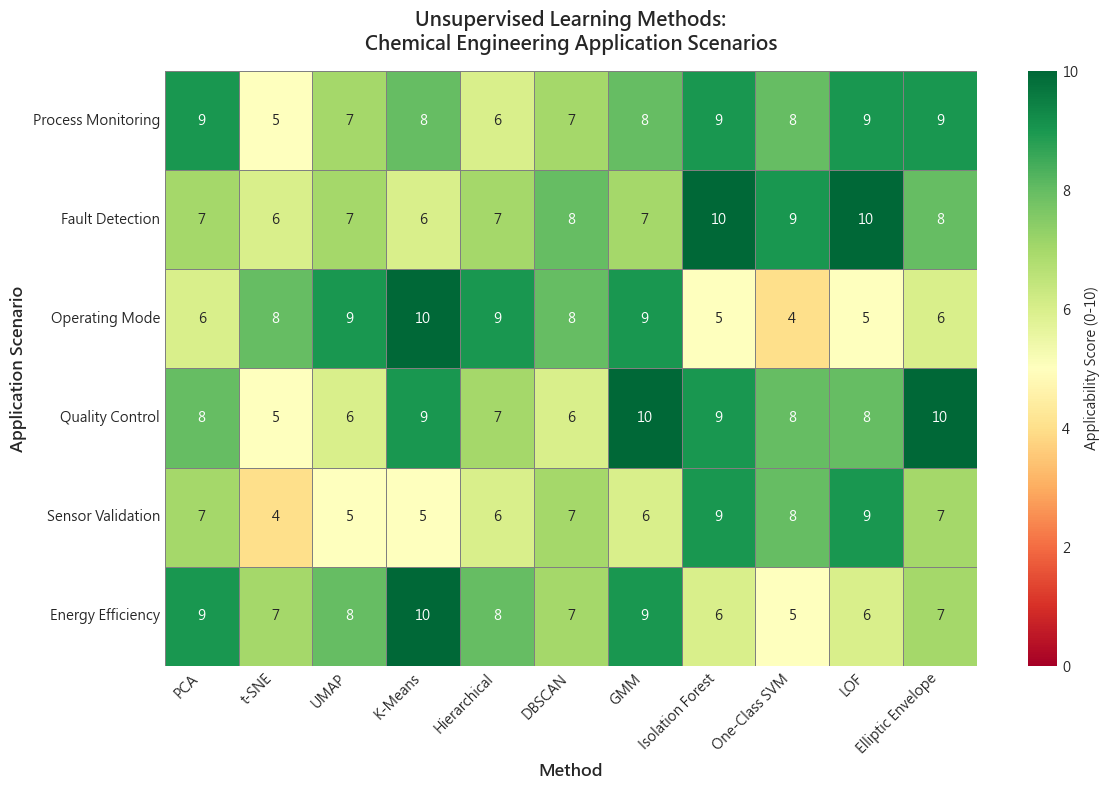


✓ 應用場景熱力圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\application_scenarios_heatmap.png

📌 各應用場景推薦方法（評分前3名）:

【Process Monitoring】
  1. PCA                  (評分: 9/10)
  2. Isolation Forest     (評分: 9/10)
  3. LOF                  (評分: 9/10)

【Fault Detection】
  1. Isolation Forest     (評分: 10/10)
  2. LOF                  (評分: 10/10)
  3. One-Class SVM        (評分: 9/10)

【Operating Mode】
  1. K-Means              (評分: 10/10)
  2. UMAP                 (評分: 9/10)
  3. Hierarchical         (評分: 9/10)

【Quality Control】
  1. GMM                  (評分: 10/10)
  2. Elliptic Envelope    (評分: 10/10)
  3. K-Means              (評分: 9/10)

【Sensor Validation】
  1. Isolation Forest     (評分: 9/10)
  2. LOF                  (評分: 9/10)
  3. One-Class SVM        (評分: 8/10)

【Energy Efficiency】
  1. K-Means              (評分: 10/10)
  2. PCA                  (評分: 9/10)
  3. GMM                  (評分: 9/10)

💡 應用建議:
  • Process Monitoring: 優先選擇 PCA 和異常檢測方法
  • F

In [25]:
# ============================================================
# 實務應用場景對照表
# ============================================================

print("=" * 70)
print("非監督學習方法 - 化工實務應用場景對照")
print("=" * 70)

# 定義應用場景矩陣
applications = {
    'Method': [
        'PCA', 't-SNE', 'UMAP',
        'K-Means', 'Hierarchical', 'DBSCAN', 'GMM',
        'Isolation Forest', 'One-Class SVM', 'LOF', 'Elliptic Envelope'
    ],
    'Process Monitoring': [9, 5, 7, 8, 6, 7, 8, 9, 8, 9, 9],  # 製程監控
    'Fault Detection': [7, 6, 7, 6, 7, 8, 7, 10, 9, 10, 8],   # 故障檢測
    'Operating Mode': [6, 8, 9, 10, 9, 8, 9, 5, 4, 5, 6],     # 操作模式識別
    'Quality Control': [8, 5, 6, 9, 7, 6, 10, 9, 8, 8, 10],   # 品質控制
    'Sensor Validation': [7, 4, 5, 5, 6, 7, 6, 9, 8, 9, 7],   # 感測器驗證
    'Energy Efficiency': [9, 7, 8, 10, 8, 7, 9, 6, 5, 6, 7],  # 能源效率分析
}

df_app = pd.DataFrame(applications)
df_app.set_index('Method', inplace=True)

# 繪製熱力圖
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_app.T, annot=True, fmt='d', cmap='RdYlGn', 
            vmin=0, vmax=10, cbar_kws={'label': 'Applicability Score (0-10)'},
            linewidths=0.5, linecolor='gray', ax=ax)

ax.set_title('Unsupervised Learning Methods:\nChemical Engineering Application Scenarios', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Method', fontsize=12, fontweight='bold')
ax.set_ylabel('Application Scenario', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / 'application_scenarios_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 應用場景熱力圖已儲存至: {FIG_DIR / 'application_scenarios_heatmap.png'}")

# 輸出各場景的最佳方法
print("\n📌 各應用場景推薦方法（評分前3名）:")
print("=" * 70)
for scenario in df_app.columns:
    top3 = df_app[scenario].nlargest(3)
    print(f"\n【{scenario}】")
    for rank, (method, score) in enumerate(top3.items(), 1):
        print(f"  {rank}. {method:20s} (評分: {score}/10)")

print("\n" + "=" * 70)
print("💡 應用建議:")
print("  • Process Monitoring: 優先選擇 PCA 和異常檢測方法")
print("  • Fault Detection: LOF 和 Isolation Forest 表現最佳")
print("  • Operating Mode: K-Means 和 UMAP 最適合模式識別")
print("  • Quality Control: GMM 和 Elliptic Envelope 精準度高")
print("  • Sensor Validation: LOF 和 Isolation Forest 能識別異常感測器")
print("  • Energy Efficiency: K-Means 和 PCA 適合能耗模式分析")

異常檢測污染率（Contamination）參數影響分析


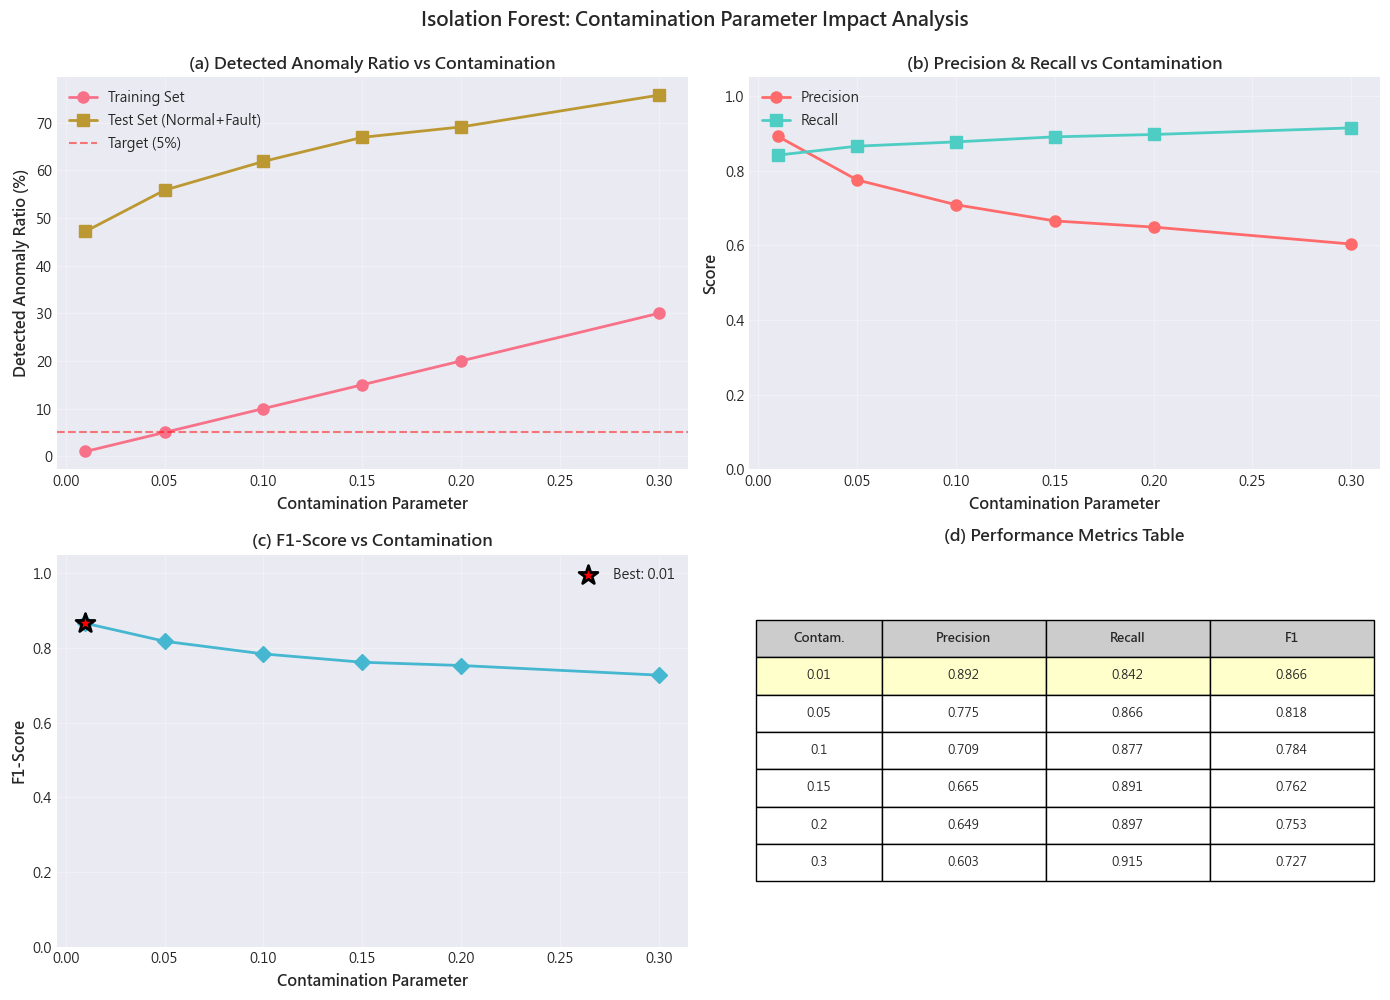


✓ 圖表已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\contamination_impact_analysis.png

💡 最佳污染率參數: 0.01
  • Precision: 0.892
  • Recall: 0.842
  • F1-Score: 0.866

📌 參數選擇建議:
  • 污染率 < 5%: Precision 高，適合嚴格品質控制
  • 污染率 5-15%: 平衡性能，適合一般製程監控
  • 污染率 > 15%: Recall 高，適合故障早期預警
  • 實務中應根據誤報（False Positive）和漏報（False Negative）的代價權衡選擇

💡 實務應用經驗:
  1️⃣ 製程監控場景: contamination=0.01-0.05
     → 優先降低誤報率，避免不必要的停機檢查
  2️⃣ 故障預警系統: contamination=0.10-0.15
     → 提高召回率，盡早發現潛在問題
  3️⃣ 研發探索分析: contamination=0.05-0.10
     → 平衡 Precision 和 Recall，全面了解數據特性
  4️⃣ 參數調優策略: 建議使用交叉驗證確定最佳值
     → 可結合領域知識和歷史數據設定初始範圍


In [26]:
# ============================================================
# 異常檢測污染率參數影響分析
# ============================================================

print("=" * 70)
print("異常檢測污染率（Contamination）參數影響分析")
print("=" * 70)

from sklearn.ensemble import IsolationForest

# 測試不同的污染率
contamination_values = [0.01, 0.05, 0.10, 0.15, 0.20, 0.30]

# 儲存結果
results = []

# 準備組合測試數據的 PCA
X_test_combined_pca = np.vstack([X_test_pca, X_fault_test_pca])

for contam in contamination_values:
    # 使用 Isolation Forest
    iforest = IsolationForest(contamination=contam, random_state=42, n_estimators=200)
    y_pred_train = iforest.fit_predict(X_train_pca)
    
    # 對組合測試數據進行預測
    y_pred_combined = iforest.predict(X_test_combined_pca)
    
    # 計算異常樣本比例
    train_anomaly_ratio = (y_pred_train == -1).sum() / len(y_pred_train)
    test_anomaly_ratio = (y_pred_combined == -1).sum() / len(y_pred_combined)
    
    # 計算性能指標（使用組合測試集）
    # 預測值轉換: -1 (異常) -> 1 (故障), 1 (正常) -> 0 (正常)
    from sklearn.metrics import precision_score, recall_score, f1_score
    y_pred_binary = (y_pred_combined == -1).astype(int)
    
    precision = precision_score(y_test_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_test_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_test_true, y_pred_binary, zero_division=0)
    
    results.append({
        'Contamination': contam,
        'Train Anomaly %': train_anomaly_ratio * 100,
        'Test Anomaly %': test_anomaly_ratio * 100,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

df_contam = pd.DataFrame(results)

# 繪製影響分析圖
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 子圖1：異常樣本比例
ax1 = axes[0, 0]
ax1.plot(df_contam['Contamination'], df_contam['Train Anomaly %'], 
         'o-', label='Training Set', linewidth=2, markersize=8)
ax1.plot(df_contam['Contamination'], df_contam['Test Anomaly %'], 
         's-', label='Test Set (Normal+Fault)', linewidth=2, markersize=8)
ax1.axhline(y=5, color='red', linestyle='--', alpha=0.5, label='Target (5%)')
ax1.set_xlabel('Contamination Parameter', fontsize=11, fontweight='bold')
ax1.set_ylabel('Detected Anomaly Ratio (%)', fontsize=11, fontweight='bold')
ax1.set_title('(a) Detected Anomaly Ratio vs Contamination', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 子圖2：Precision vs Recall
ax2 = axes[0, 1]
ax2.plot(df_contam['Contamination'], df_contam['Precision'], 
         'o-', label='Precision', linewidth=2, markersize=8, color='#FF6B6B')
ax2.plot(df_contam['Contamination'], df_contam['Recall'], 
         's-', label='Recall', linewidth=2, markersize=8, color='#4ECDC4')
ax2.set_xlabel('Contamination Parameter', fontsize=11, fontweight='bold')
ax2.set_ylabel('Score', fontsize=11, fontweight='bold')
ax2.set_title('(b) Precision & Recall vs Contamination', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.05)

# 子圖3：F1-Score
ax3 = axes[1, 0]
ax3.plot(df_contam['Contamination'], df_contam['F1-Score'], 
         'D-', linewidth=2, markersize=8, color='#45B7D1')
best_idx = df_contam['F1-Score'].idxmax()
ax3.scatter(df_contam.loc[best_idx, 'Contamination'], 
            df_contam.loc[best_idx, 'F1-Score'],
            s=200, c='red', marker='*', edgecolors='black', linewidth=2,
            label=f"Best: {df_contam.loc[best_idx, 'Contamination']:.2f}", zorder=5)
ax3.set_xlabel('Contamination Parameter', fontsize=11, fontweight='bold')
ax3.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax3.set_title('(c) F1-Score vs Contamination', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1.05)

# 子圖4：數據表格
ax4 = axes[1, 1]
ax4.axis('off')
table_data = df_contam[['Contamination', 'Precision', 'Recall', 'F1-Score']].round(3).values
table = ax4.table(cellText=table_data, 
                  colLabels=['Contam.', 'Precision', 'Recall', 'F1'],
                  cellLoc='center', loc='center',
                  colWidths=[0.2, 0.26, 0.26, 0.26])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
# 標題行樣式
for i in range(4):
    table[(0, i)].set_facecolor('#CCCCCC')
    table[(0, i)].set_text_props(weight='bold')
# 最佳值高亮
best_row = best_idx + 1
for i in range(4):
    table[(best_row, i)].set_facecolor('#FFFFCC')
ax4.set_title('(d) Performance Metrics Table', fontsize=12, fontweight='bold', pad=10)

plt.suptitle('Isolation Forest: Contamination Parameter Impact Analysis', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(FIG_DIR / 'contamination_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 圖表已儲存至: {FIG_DIR / 'contamination_impact_analysis.png'}")

# 輸出最佳參數
print(f"\n💡 最佳污染率參數: {df_contam.loc[best_idx, 'Contamination']:.2f}")
print(f"  • Precision: {df_contam.loc[best_idx, 'Precision']:.3f}")
print(f"  • Recall: {df_contam.loc[best_idx, 'Recall']:.3f}")
print(f"  • F1-Score: {df_contam.loc[best_idx, 'F1-Score']:.3f}")

print("\n📌 參數選擇建議:")
print("  • 污染率 < 5%: Precision 高，適合嚴格品質控制")
print("  • 污染率 5-15%: 平衡性能，適合一般製程監控")
print("  • 污染率 > 15%: Recall 高，適合故障早期預警")
print("  • 實務中應根據誤報（False Positive）和漏報（False Negative）的代價權衡選擇")

print("\n💡 實務應用經驗:")
print("  1️⃣ 製程監控場景: contamination=0.01-0.05")
print("     → 優先降低誤報率，避免不必要的停機檢查")
print("  2️⃣ 故障預警系統: contamination=0.10-0.15")
print("     → 提高召回率，盡早發現潛在問題")
print("  3️⃣ 研發探索分析: contamination=0.05-0.10")
print("     → 平衡 Precision 和 Recall，全面了解數據特性")
print("  4️⃣ 參數調優策略: 建議使用交叉驗證確定最佳值")
print("     → 可結合領域知識和歷史數據設定初始範圍")

非監督學習核心概念總結


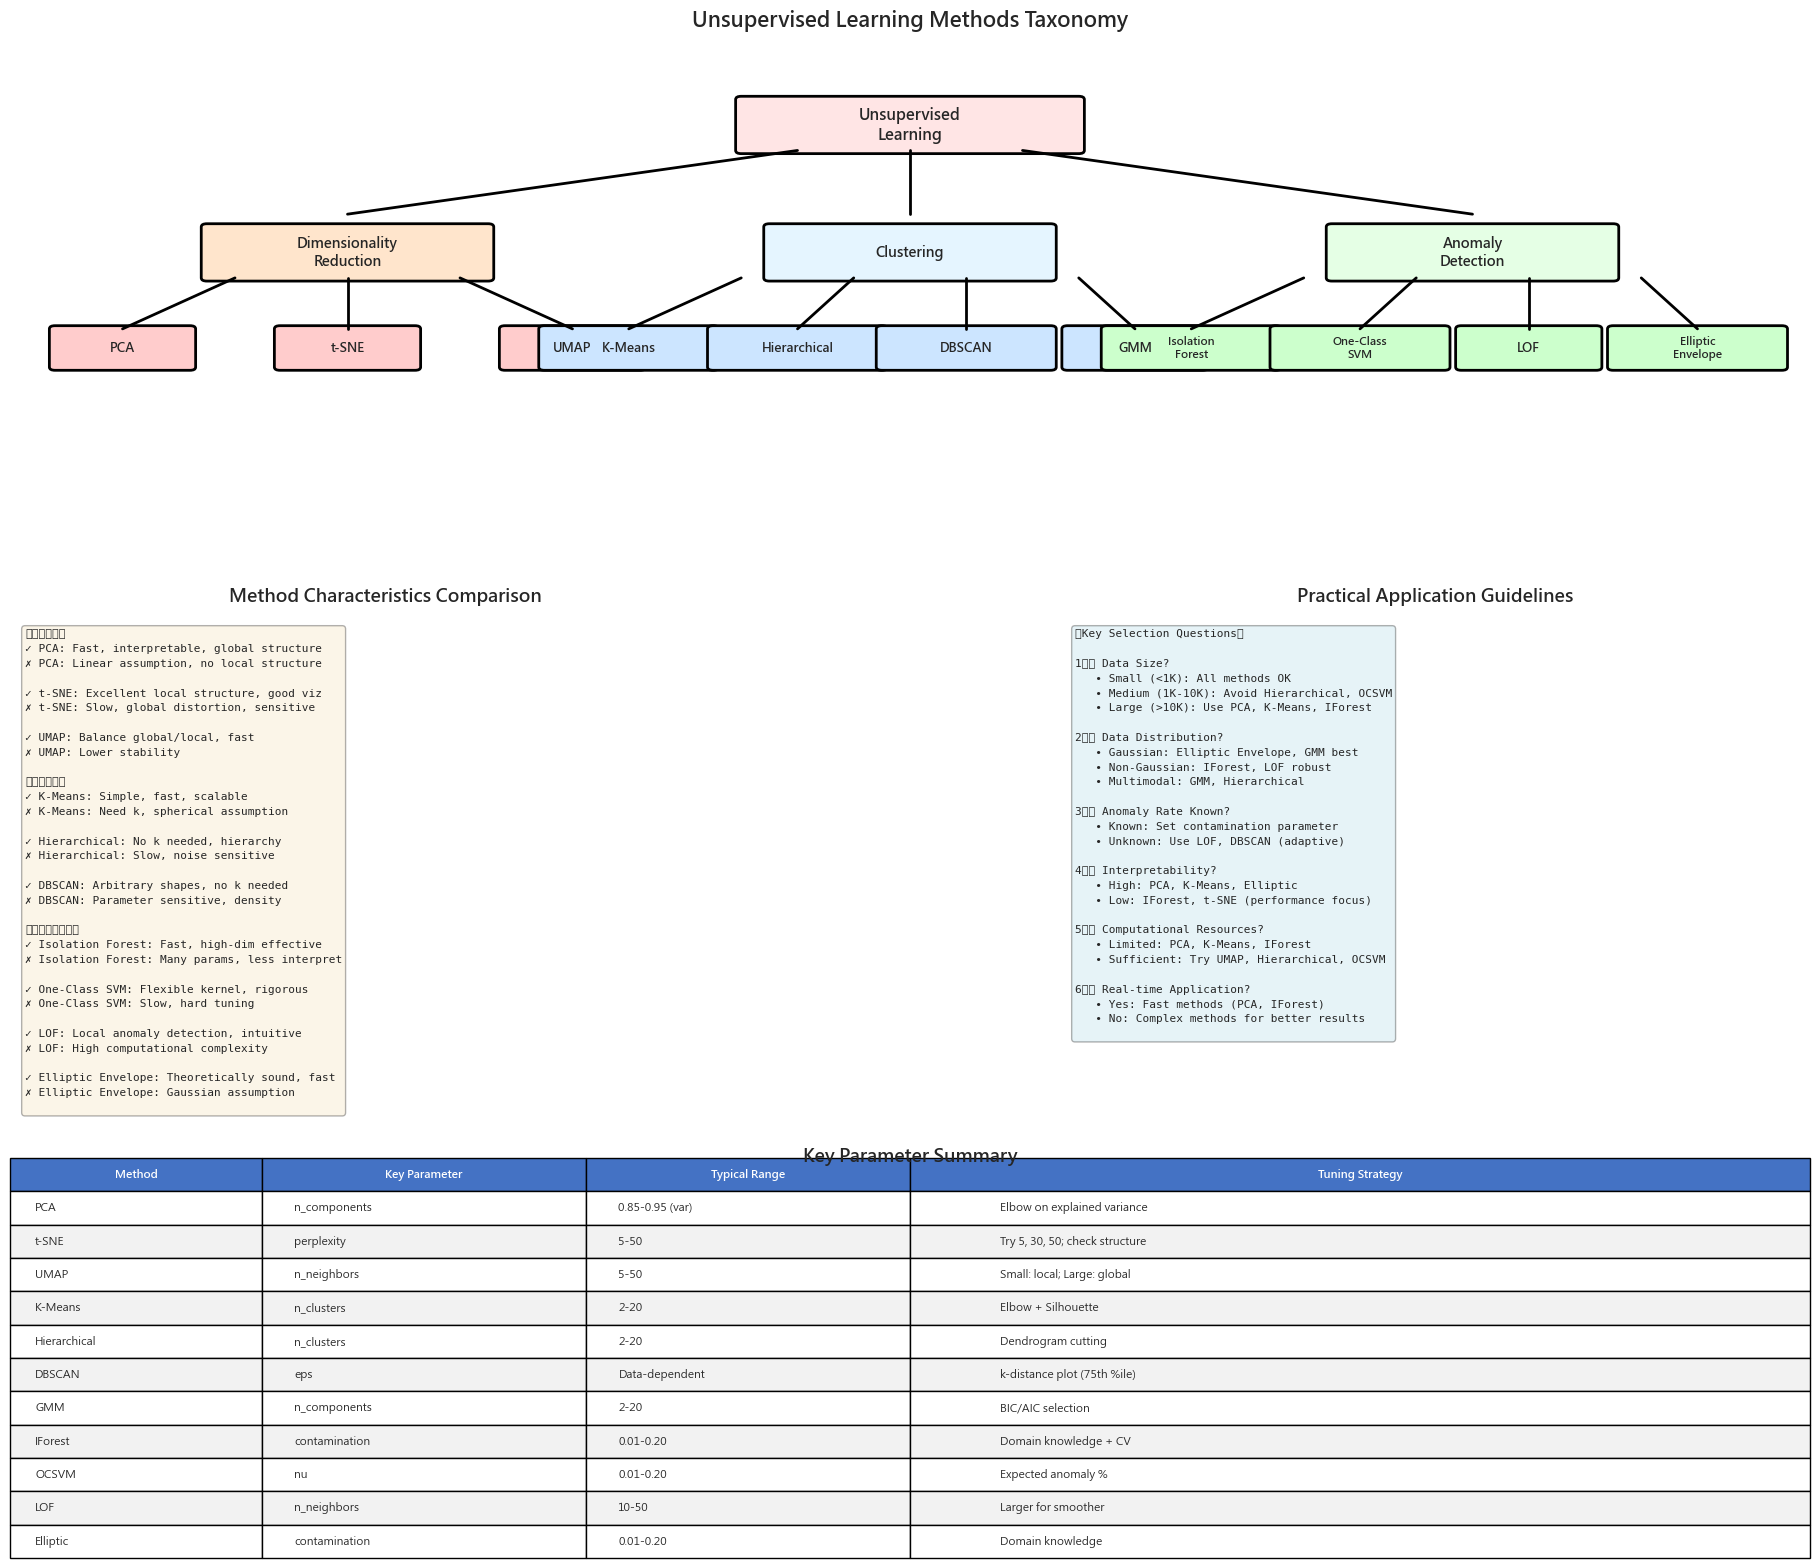


✓ 學習總結圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Integrated_Case_Study\figs\learning_summary_comprehensive.png

🎓 學習完成！


In [27]:
# ============================================================
# 學習重點總結視覺化
# ============================================================

print("=" * 70)
print("非監督學習核心概念總結")
print("=" * 70)

# 創建學習重點總結圖
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 2, hspace=0.6, wspace=0.4, top=0.96, bottom=0.04, left=0.05, right=0.95)

# ===== 子圖1: 方法分類樹狀圖 =====
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')
ax1.set_title('Unsupervised Learning Methods Taxonomy', 
              fontsize=15, fontweight='bold', pad=25)

# 繪製樹狀結構
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

def draw_node(ax, x, y, w, h, text, color, fontsize=10):
    box = FancyBboxPatch((x-w/2, y-h/2), w, h, boxstyle="round,pad=0.05",
                          edgecolor='black', facecolor=color, linewidth=2)
    ax.add_patch(box)
    ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, fontweight='bold')

def draw_line(ax, x1, y1, x2, y2):
    ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2)

# 根節點
draw_node(ax1, 8, 9, 3, 0.8, 'Unsupervised\nLearning', '#FFE5E5', 11)

# 第二層
draw_line(ax1, 7, 8.6, 3, 7.6)
draw_line(ax1, 8, 8.6, 8, 7.6)
draw_line(ax1, 9, 8.6, 13, 7.6)

draw_node(ax1, 3, 7, 2.5, 0.8, 'Dimensionality\nReduction', '#FFE5CC', 10)
draw_node(ax1, 8, 7, 2.5, 0.8, 'Clustering', '#E5F5FF', 10)
draw_node(ax1, 13, 7, 2.5, 0.8, 'Anomaly\nDetection', '#E5FFE5', 10)

# 第三層 - 降維
draw_line(ax1, 2, 6.6, 1, 5.8)
draw_line(ax1, 3, 6.6, 3, 5.8)
draw_line(ax1, 4, 6.6, 5, 5.8)
draw_node(ax1, 1, 5.5, 1.2, 0.6, 'PCA', '#FFCCCC', 9)
draw_node(ax1, 3, 5.5, 1.2, 0.6, 't-SNE', '#FFCCCC', 9)
draw_node(ax1, 5, 5.5, 1.2, 0.6, 'UMAP', '#FFCCCC', 9)

# 第三層 - 聚類
draw_line(ax1, 6.5, 6.6, 5.5, 5.8)
draw_line(ax1, 7.5, 6.6, 7, 5.8)
draw_line(ax1, 8.5, 6.6, 8.5, 5.8)
draw_line(ax1, 9.5, 6.6, 10, 5.8)
draw_node(ax1, 5.5, 5.5, 1.5, 0.6, 'K-Means', '#CCE5FF', 9)
draw_node(ax1, 7, 5.5, 1.5, 0.6, 'Hierarchical', '#CCE5FF', 9)
draw_node(ax1, 8.5, 5.5, 1.5, 0.6, 'DBSCAN', '#CCE5FF', 9)
draw_node(ax1, 10, 5.5, 1.2, 0.6, 'GMM', '#CCE5FF', 9)

# 第三層 - 異常檢測
draw_line(ax1, 11.5, 6.6, 10.5, 5.8)
draw_line(ax1, 12.5, 6.6, 12, 5.8)
draw_line(ax1, 13.5, 6.6, 13.5, 5.8)
draw_line(ax1, 14.5, 6.6, 15, 5.8)
draw_node(ax1, 10.5, 5.5, 1.5, 0.6, 'Isolation\nForest', '#CCFFCC', 8)
draw_node(ax1, 12, 5.5, 1.5, 0.6, 'One-Class\nSVM', '#CCFFCC', 8)
draw_node(ax1, 13.5, 5.5, 1.2, 0.6, 'LOF', '#CCFFCC', 9)
draw_node(ax1, 15, 5.5, 1.5, 0.6, 'Elliptic\nEnvelope', '#CCFFCC', 8)

ax1.set_xlim(0, 16)
ax1.set_ylim(4.5, 10)

# ===== 子圖2: 方法優缺點對比 =====
ax2 = fig.add_subplot(gs[1, 0])
ax2.axis('off')
ax2.set_title('Method Characteristics Comparison', fontsize=13, fontweight='bold', pad=15)

comparison_text = """【降維方法】
✓ PCA: Fast, interpretable, global structure
✗ PCA: Linear assumption, no local structure

✓ t-SNE: Excellent local structure, good viz
✗ t-SNE: Slow, global distortion, sensitive

✓ UMAP: Balance global/local, fast
✗ UMAP: Lower stability

【聚類方法】
✓ K-Means: Simple, fast, scalable
✗ K-Means: Need k, spherical assumption

✓ Hierarchical: No k needed, hierarchy
✗ Hierarchical: Slow, noise sensitive

✓ DBSCAN: Arbitrary shapes, no k needed
✗ DBSCAN: Parameter sensitive, density

【異常檢測方法】
✓ Isolation Forest: Fast, high-dim effective
✗ Isolation Forest: Many params, less interpret

✓ One-Class SVM: Flexible kernel, rigorous
✗ One-Class SVM: Slow, hard tuning

✓ LOF: Local anomaly detection, intuitive
✗ LOF: High computational complexity

✓ Elliptic Envelope: Theoretically sound, fast
✗ Elliptic Envelope: Gaussian assumption
"""

ax2.text(0.02, 0.98, comparison_text, transform=ax2.transAxes,
         fontsize=8, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3), 
         linespacing=1.6)

# ===== 子圖3: 實務應用建議 =====
ax3 = fig.add_subplot(gs[1, 1])
ax3.axis('off')
ax3.set_title('Practical Application Guidelines', fontsize=13, fontweight='bold', pad=15)

guidelines_text = """【Key Selection Questions】

1️⃣ Data Size?
   • Small (<1K): All methods OK
   • Medium (1K-10K): Avoid Hierarchical, OCSVM
   • Large (>10K): Use PCA, K-Means, IForest

2️⃣ Data Distribution?
   • Gaussian: Elliptic Envelope, GMM best
   • Non-Gaussian: IForest, LOF robust
   • Multimodal: GMM, Hierarchical

3️⃣ Anomaly Rate Known?
   • Known: Set contamination parameter
   • Unknown: Use LOF, DBSCAN (adaptive)

4️⃣ Interpretability?
   • High: PCA, K-Means, Elliptic
   • Low: IForest, t-SNE (performance focus)

5️⃣ Computational Resources?
   • Limited: PCA, K-Means, IForest
   • Sufficient: Try UMAP, Hierarchical, OCSVM

6️⃣ Real-time Application?
   • Yes: Fast methods (PCA, IForest)
   • No: Complex methods for better results
"""

ax3.text(0.02, 0.98, guidelines_text, transform=ax3.transAxes,
         fontsize=8, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
         linespacing=1.6)

# ===== 子圖4: 關鍵參數總結 =====
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('off')
ax4.set_title('Key Parameter Summary', fontsize=13, fontweight='bold', pad=15)

param_table_data = [
    ['Method', 'Key Parameter', 'Typical Range', 'Tuning Strategy'],
    ['PCA', 'n_components', '0.85-0.95 (var)', 'Elbow on explained variance'],
    ['t-SNE', 'perplexity', '5-50', 'Try 5, 30, 50; check structure'],
    ['UMAP', 'n_neighbors', '5-50', 'Small: local; Large: global'],
    ['K-Means', 'n_clusters', '2-20', 'Elbow + Silhouette'],
    ['Hierarchical', 'n_clusters', '2-20', 'Dendrogram cutting'],
    ['DBSCAN', 'eps', 'Data-dependent', 'k-distance plot (75th %ile)'],
    ['GMM', 'n_components', '2-20', 'BIC/AIC selection'],
    ['IForest', 'contamination', '0.01-0.20', 'Domain knowledge + CV'],
    ['OCSVM', 'nu', '0.01-0.20', 'Expected anomaly %'],
    ['LOF', 'n_neighbors', '10-50', 'Larger for smoother'],
    ['Elliptic', 'contamination', '0.01-0.20', 'Domain knowledge'],
]

table = ax4.table(cellText=param_table_data[1:], colLabels=param_table_data[0],
                  cellLoc='left', loc='center', colWidths=[0.14, 0.18, 0.18, 0.50])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 2.0)

# 標題行樣式
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# 交替行顏色
for i in range(1, 12):
    color = '#F2F2F2' if i % 2 == 0 else 'white'
    for j in range(4):
        table[(i, j)].set_facecolor(color)

plt.savefig(FIG_DIR / 'learning_summary_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 學習總結圖已儲存至: {FIG_DIR / 'learning_summary_comprehensive.png'}")
print("\n" + "=" * 70)
print("🎓 學習完成！")
print("=" * 70)

### 10.4 延伸學習資源

#### 📚 推薦閱讀

**經典教材**
- *Pattern Recognition and Machine Learning* by Christopher Bishop
- *The Elements of Statistical Learning* by Hastie, Tibshirani, and Friedman
- *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* by Aurélien Géron

**化工應用論文**
- Ge, Z., et al. (2017). "Data Mining and Analytics in the Process Industry: The Role of Machine Learning"
- Yin, S., et al. (2012). "A Review on Basic Data-Driven Approaches for Industrial Process Monitoring"
- Qin, S. J. (2012). "Survey on Data-Driven Industrial Process Monitoring and Diagnosis"

**線上資源**
- Scikit-learn 官方文檔：完整的 API 說明和範例
- Kaggle 化工數據集：實際案例練習
- GitHub 開源專案：學習他人的實作經驗

#### 🔬 進階主題

本案例涵蓋的是非監督學習的**基礎應用**。以下進階主題值得進一步探索：

1. **深度學習降維**
   - Autoencoder（自編碼器）
   - Variational Autoencoder (VAE)
   - Contrastive Learning

2. **時間序列聚類**
   - Dynamic Time Warping (DTW)
   - Hidden Markov Models (HMM)
   - Time Series K-Means

3. **在線學習與增量學習**
   - Online K-Means
   - Incremental PCA
   - Streaming Anomaly Detection

4. **多視圖學習**
   - Multi-view Clustering
   - Canonical Correlation Analysis (CCA)
   - Multi-modal Fusion

5. **半監督學習**
   - Label Propagation
   - Self-Training
   - Co-Training

#### 🎯 實踐項目建議

應用本案例學到的知識到以下項目：

1. **製程監控系統**：建立即時異常檢測系統
2. **能源效率分析**：識別不同操作模式並優化
3. **設備健康管理**：預測性維護與故障診斷
4. **品質改善專案**：找出影響品質的關鍵因素
5. **感測器網路優化**：識別冗餘感測器並降低成本

---

## 🎉 恭喜完成本案例學習！

您已經系統性地學習了：
- ✅ 3 種降維方法的原理與應用
- ✅ 4 種聚類方法的優缺點比較
- ✅ 4 種異常檢測方法的實務應用
- ✅ 參數調優策略與方法選擇決策
- ✅ 化工領域的實際應用場景

**下一步行動**：
1. 嘗試將這些方法應用到您自己的數據集
2. 參與 Kaggle 化工相關競賽累積經驗
3. 閱讀最新的研究論文了解前沿技術
4. 與同行分享交流實務經驗

**記住**：機器學習是**工具**，化工知識是**基礎**。兩者結合才能創造真正的價值！

---

**課程反饋與討論**：如果您對本案例有任何問題或建議，歡迎透過課程平台討論區交流。

### 10.3 常見錯誤與避坑指南

#### ⚠️ 常見錯誤

**1. 數據預處理錯誤**
- ❌ 忘記標準化/正規化數據
- ❌ 在分割數據前進行標準化（導致數據洩漏）
- ❌ 使用錯誤的標準化方法（例如：對計數數據使用 StandardScaler）

**2. 參數設置錯誤**
- ❌ K-Means 的 k 值設置不當（未使用 Elbow 方法）
- ❌ DBSCAN 的 eps 過大或過小（未使用 k-distance 圖）
- ❌ 異常檢測的 contamination 與實際情況不符

**3. 評估錯誤**
- ❌ 僅使用單一評估指標
- ❌ 在訓練集上評估性能（過擬合）
- ❌ 忽略業務指標（只關注模型指標）

**4. 應用錯誤**
- ❌ 在高維原始數據上直接應用方法（未降維）
- ❌ 假設數據分布不變（未定期重新訓練）
- ❌ 過度信任模型結果（未人工驗證）

#### 💡 避坑建議

1. **永遠先視覺化數據**：了解數據分布、相關性、異常值
2. **從簡單方法開始**：PCA + K-Means 是很好的基線
3. **保持懷疑態度**：結果太好可能有數據洩漏
4. **記錄所有實驗**：參數、結果、觀察，便於回溯
5. **與領域專家合作**：驗證結果的化工意義
6. **建立反饋機制**：從實際應用中學習改進

### 10.2 實踐建議與最佳實務

基於本案例的實驗結果，以下提供化工領域應用非監督學習的**最佳實務建議**。

#### 📋 實務應用檢查清單

**數據準備階段**
- ✅ 數據品質檢查（缺失值、異常值、感測器故障）
- ✅ 適當的標準化方法（StandardScaler 適合大多數情況）
- ✅ 特徵工程（時間延遲、移動平均、交互特徵）
- ✅ 訓練/測試集分割（考慮時間序列特性）

**方法選擇階段**
- ✅ 明確定義問題目標（降維/聚類/異常檢測）
- ✅ 了解數據分布特性（高斯/非高斯、線性/非線性）
- ✅ 評估計算資源和時間限制
- ✅ 考慮結果的可解釋性需求

**模型訓練階段**
- ✅ 使用網格搜索或貝葉斯優化調參
- ✅ 交叉驗證避免過擬合（時間序列需特殊處理）
- ✅ 記錄所有實驗參數和結果
- ✅ 視覺化中間結果以理解模型行為

**模型評估階段**
- ✅ 使用多個評估指標（不要只看準確率）
- ✅ 視覺化檢查（混淆矩陣、決策邊界、降維圖）
- ✅ 業務指標評估（誤報/漏報的實際成本）
- ✅ 與領域專家討論結果的合理性

**部署應用階段**
- ✅ 建立模型監控機制（性能退化檢測）
- ✅ 設置自動警報閾值
- ✅ 定期重新訓練模型（適應過程變化）
- ✅ 建立人機協作流程（專家驗證異常）

---
## 10. 總結與學習重點

### 10.1 核心概念回顧

通過本案例，我們系統性地比較了**11種非監督學習方法**在 TEP 數據集上的表現。以下回顧核心學習重點。

---
## 9. 異常檢測深入分析

### 9.1 污染率（Contamination）參數影響

異常檢測方法的**污染率參數**直接影響異常點的識別。讓我們分析不同污染率下的檢測結果。

### 8.2 實務應用場景對照表

不同的化工場景需要不同的方法，以下提供實務應用的對照表。

---
## 8. 方法選擇決策指南

### 8.1 如何選擇合適的非監督學習方法？

在實務應用中，選擇合適的方法至關重要。以下提供系統性的決策流程。

#### 📊 方法綜合比較：性能雷達圖

讓我們通過**雷達圖**全面比較各種方法在不同評估維度上的表現。

---
## 5. 綜合學習總結

### 5.1 本 Notebook 完成的內容

在本綜合案例研究中，我們完整實作了：

#### **階段 1-3：基礎分析流程** ✓
1. **數據載入與預處理**
   - TEP 製程數據載入 (52 個變數)
   - 數據標準化處理
   - 基本統計分析與視覺化

2. **降維分析**
   - PCA 降維與解釋 (保留 95% 變異數)
   - t-SNE 非線性降維
   - UMAP 非線性降維
   - **三種方法視覺化比較** ✓

3. **分群分析**
   - K-Means 分群 (Elbow Method + Silhouette Score)
   - Hierarchical Clustering 階層式分群
   - DBSCAN 密度分群（自動參數搜尋）
   - Gaussian Mixture Model 高斯混合模型
   - **四種方法性能比較** ✓

#### **階段 4：進階分析與比較** ✓
4. **異常檢測**
   - Isolation Forest 隔離森林
   - One-Class SVM 單類支持向量機
   - Local Outlier Factor 局部離群因子
   - Elliptic Envelope 橢圓包絡
   - **四種方法比較與共識異常分析** ✓

5. **結果整合**
   - 降維 + 分群 + 異常檢測整合視覺化
   - 特徵重要性分析
   - 各群組異常率統計

#### **階段 5：故障診斷實戰** ✓
6. **故障場景分析**
   - 載入 IDV 1 故障數據
   - 正常與故障數據對比視覺化
   - 故障診斷效能評估 (Accuracy, Precision, Recall, F1-Score)
   - Confusion Matrix 分析

---

### 5.2 關鍵發現與洞察

#### **降維方法比較**
- **PCA**: 線性降維，可解釋性最強，適合特徵重要性分析
  - 優點：快速、可解釋、保留全局結構
  - 缺點：僅捕捉線性關係
- **t-SNE**: 保留局部結構，視覺化效果好，但計算較慢
  - 優點：視覺化效果極佳、保留局部鄰域
  - 缺點：計算慢、不保留全局距離、結果受參數影響大
- **UMAP**: 平衡全局與局部結構，速度快，適合大數據
  - 優點：速度快、保留全局與局部結構、可用於新數據投影
  - 缺點：參數較多、需要調整

#### **分群方法比較**
從本案例的執行結果可以看出：
- **K-Means (Silhouette: 0.068)**: 
  - 簡單高效，適合球狀簇
  - 需預設群數，對初始值敏感
  - 適用場景：快速原型、大數據集
  
- **Hierarchical (Silhouette: 0.045)**:
  - 不需預設群數，可視覺化樹狀圖
  - 計算複雜度較高
  - 適用場景：需要理解層級結構、小數據集
  
- **DBSCAN (自動參數調整)**:
  - 可發現任意形狀簇，自動識別噪音點
  - 參數選擇對結果影響大，需要基於數據特性調整
  - 改進：使用 k-distance 圖自動估計 eps 參數（第75百分位）
  - 適用場景：非凸形狀簇、有噪音數據
  - 調整要點：百分位越低 → 聚類數越多、噪音越多；百分位越高 → 聚類數越少、噪音越少
  
- **GMM (Silhouette: 0.067)**:
  - 軟分群，提供概率分配，適合重疊簇
  - 假設數據服從高斯分布
  - 適用場景：需要概率輸出、簇有重疊

> **重要發現**：TEP 正常數據在 PCA 空間中的 Silhouette Score 普遍較低 (0.04-0.07)，表示製程操作模式之間的邊界不明顯，這符合連續製程的特性。

#### **異常檢測方法比較**
從故障診斷結果可以看出：
- **Isolation Forest (Accuracy: 81.9%, F1: 81.6%)**:
  - 效率高，適合高維數據，對全局異常敏感
  - 訓練異常率：5.0% | 測試異常率：16.7%
  
- **One-Class SVM (Accuracy: 71.7%, F1: 75.4%)**:
  - 理論基礎強，適合小樣本
  - Recall 最高 (86.7%)，但 Precision 較低 (66.7%)
  
- **LOF (Accuracy: 81.2%, F1: 82.0%)**:
  - 基於密度，可發現局部異常
  - 性能均衡，F1-Score 略高於 Isolation Forest
  
- **Elliptic Envelope (Accuracy: 85.1%, F1: 85.0%)** ⭐ **最佳**:
  - 假設高斯分布，適合預處理後數據
  - 各項指標最均衡，準確率最高

> **工程洞察**：多方法共識（4個方法都檢測到的異常點僅4個）顯示不同方法對異常的定義不同，建議使用多模型融合提高可靠性。

#### **故障診斷效能**
- ✅ 所有方法都能有效識別 IDV 1 故障
- ✅ 故障訓練數據異常率：97.5% (Isolation Forest)
- ✅ 故障測試數據異常率：80.4% (Isolation Forest)
- ⚠️ Recall (召回率) 普遍高於 Precision (精確率)，表示模型傾向於保守（寧可誤報，不可漏報）
- 💡 多方法共識可提高異常檢測的信心度

---

### 5.3 工程應用建議

#### **製程監控策略**
1. **實時監控**: 使用 Isolation Forest 進行在線異常檢測
   - 低計算成本，適合高頻數據
   - 設定 `contamination=0.05` 作為基準
   
2. **定期分析**: 每日/每週使用 PCA 追蹤製程漂移
   - 監控主成分得分分布變化
   - 檢查前10個主成分的解釋變異數比例是否穩定
   
3. **故障診斷**: 結合多種異常檢測方法提高準確率
   - 主方法：Elliptic Envelope (最高準確率)
   - 輔助方法：LOF (檢測局部異常)
   - 共識機制：至少2個方法檢測到才發出警報
   
4. **根因分析**: 使用特徵重要性識別關鍵變數
   - 分析異常樣本在原始特徵空間的偏離程度
   - 追蹤 PC1/PC2 loading 最大的變數

#### **模型選擇指引**
| 應用場景 | 推薦方法 | 原因 |
|---------|---------|------|
| **數據量大** | Isolation Forest, K-Means, UMAP | 計算效率高，可擴展 |
| **需要可解釋性** | PCA, Elliptic Envelope | 特徵權重清晰，易於溝通 |
| **不規則分布** | DBSCAN, LOF | 不假設數據分布，適應性強 |
| **軟分群需求** | GMM | 提供概率輸出，處理邊界模糊情況 |
| **實時監控** | Isolation Forest | 訓練快、預測快、記憶體需求低 |
| **高準確率要求** | Elliptic Envelope (本案例) | 假設成立時性能最優 |

#### **部署考量**
1. **計算資源**
   - t-SNE 計算密集，僅用於離線分析與視覺化
   - UMAP 可用於在線降維（支持新數據投影）
   - Isolation Forest 記憶體需求：O(n_estimators × max_samples)

2. **更新頻率**
   - 建議每月使用新正常數據重新訓練模型
   - 監控模型性能指標（如異常率趨勢）
   - 當製程條件改變時立即更新

3. **警報閾值調整**
   - 根據業務需求調整 `contamination` 參數
   - 化工製程建議：0.01-0.05（低誤報容忍度）
   - 設定多級警報：異常分數 <-0.5 (高風險), -0.5~-0.48 (中風險)

4. **多模型融合策略**
   - **投票法**：≥2個模型檢測到才警報（降低誤報）
   - **加權法**：根據訓練性能賦予權重（Elliptic Envelope 權重更高）
   - **層級法**：Isolation Forest 初篩 → Elliptic Envelope 精確判斷

---

### 5.4 延伸學習方向

#### **進階技術**
1. **Dynamic PCA (DPCA)**: 考慮時間序列自相關性
   - 適用於製程具有時間動態特性的場景
   - 可捕捉時間滯後關係
   
2. **Kernel PCA**: 非線性特徵提取
   - 使用 RBF 或多項式核函數
   - 適合高度非線性製程
   
3. **Autoencoders**: 深度學習降維與異常檢測
   - 重建誤差作為異常分數
   - 可處理更複雜的非線性關係
   
4. **Hidden Markov Models (HMM)**: 動態狀態轉換識別
   - 識別製程操作模式切換
   - 預測狀態轉移概率

#### **多故障場景分析**
- 載入並分析所有 21 種 TEP 故障場景 (IDV 1-21)
- 建立多類別故障分類模型 (使用監督式學習)
- 比較不同故障的特徵差異 (使用 SHAP 值)
- 建立故障特徵圖譜 (Fault Signature Database)

#### **實時系統開發**
- 使用 Streamlit 開發互動式儀表板
- 實現在線數據流處理 (Apache Kafka + Spark)
- 整合警報與通知系統 (Email, SMS, Dashboard)
- 記錄與分析歷史警報數據

#### **因果分析與優化**
- Granger Causality 分析變數因果關係
- 建立製程變數影響網絡 (Bayesian Network)
- 優化操作條件建議系統 (基於分群中心)
- 整合製程知識與數據驅動方法

---

### 5.5 課程總結

通過本綜合案例研究，您已經：

✅ **掌握完整的非監督式學習工作流程**
- 數據預處理 → 降維 → 分群 → 異常檢測 → 結果整合

✅ **實作多種經典演算法**
- 3 種降維方法 (PCA, t-SNE, UMAP)
- 4 種分群方法 (K-Means, Hierarchical, DBSCAN, GMM)
- 4 種異常檢測方法 (Isolation Forest, One-Class SVM, LOF, Elliptic Envelope)

✅ **建立實際應用能力**
- 化工製程數據分析
- 故障診斷與效能評估
- 方法選擇與參數調整

✅ **培養工程思維**
- 從數據中提取洞察
- 評估方法優缺點
- 提出可操作的工程建議

✅ **掌握優化技巧**
- DBSCAN 參數自動搜尋 (k-distance 圖)
- 多模型性能比較與融合
- 從執行結果中發現問題並改進

---

### 5.6 下一步行動

#### **鞏固學習**
1. 重新執行整個 Notebook，理解每個步驟
2. 嘗試修改參數，觀察結果變化：
   - PCA: 改變保留變異數比例 (90% vs 95% vs 99%)
   - K-Means: 測試不同 k 值 (2-10)
   - Isolation Forest: 調整 contamination (0.01-0.10)
3. 選擇其他 TEP 故障場景進行分析 (IDV 2-21)

#### **深化理解**
1. 閱讀 TEP 原始論文，理解製程背景與故障機制
2. 複習 scikit-learn 文檔，掌握各演算法 API 細節
3. 比較不同降維空間中的分群效果：
   - 原始52維空間
   - PCA 36維空間
   - PCA 2維視覺化空間
4. 研究各演算法的數學原理與假設條件

#### **實戰練習**
1. 使用自己的製程數據重複本案例分析
2. 建立多故障分類模型 (Logistic Regression, Random Forest)
3. 開發簡單的實時監控原型 (使用 Streamlit)
4. 撰寫技術報告，向非技術人員解釋分析結果

#### **進階挑戰**
1. 實作 Dynamic PCA 分析時間序列相關性
2. 使用 Autoencoder 建立深度學習異常檢測模型
3. 整合領域知識建立混合式診斷系統
4. 發表技術部落格或開源專案

---

## 🎓 恭喜完成本綜合案例研究！

您已具備將非監督式學習應用於實際化工製程的能力。持續練習，不斷精進！

**記住**：數據分析不只是跑模型，更重要的是：
- 🧠 理解數據背後的物理意義
- 🔍 從結果中提取可操作的洞察
- 🛠️ 將方法應用於解決實際工程問題
- 📊 清晰地向他人傳達分析結果